# Critical Heat Flux (CHF) Prediction

**Inputs**

- `D (m)`: Diameter of the test section ($0.002 - 0.016~m$) 
- `L (m)`: Heated length ($0.07 - 15.0~m$)
- `P (kPa)`: Pressure ($100 - 20,000~kPa$)
- `G (kg m-2s-1)`: Mass flux ($17.7 - 7712.0~\frac{kg}{m^2\cdot s}$)
- `Tin (C)`: Inlet temperature length ($9.0 - 353.62 ^\circ C$)
- `Xe (-)`: Outlet equilibrium quality ($-0.445 - 0.986$)

**Output**

- `CHF (kW m-2)`: Critical heat flux ($130.0 - 13345.0~\frac{kW}{m^2}$)

The CHF dataset was taken from the Nuclear Regulatory Commission CHF database. This dataset was generated from vertical water-cooled uniformly heated tubes, producing 24,579 samples from 59 different sources of measurements. The dataset was collected over experimental measurements spanning 60 years of CHF data collection methods such as visual identification, physical burnout, changes in the test section resistances, and the usage of thermocouples. The parameters collected consist of pressure ($P$), test section diameter ($D$), heated length ($L$), mass flux ($G$), inlet temperature ($T_{in}$), outlet equilibrium quality ($X$), and $CHF$. 

Negative quality $X$ could represent a subcooled fluid. The database was limited in terms of diameter (2 $<$ D $<$ 25 mm), $L/D$ ratio ($L/D$ $>$ 50 for X $>$ 0, $L/D$ $>$ 25 for X $<$ 0), pressure (100 $\leq$ P $\leq$ 21,000 kPa) and mass flux (0 $\leq$ G $<$ 8,000 kg/m2/s). The measured data was also not equally distributed over the whole span, and no data beyond $D$ = 16 mm was found in the database. **Our goal is to identify optimal ML models with pyMIASE that can predict CHF accurately given other geometrical parameters and boundary conditions ($D, L, P, G, T_{in}, X$).**

**Important Note**: This dataset is confidential, it is not open-sourced with pyMAISE and can be requested directly from the OECD Nuclear Energy Agency (NEA). In this notebook, we provide 2500 synthetic samples that mimic the real ones (split into 2000 train and 500 test samples). The synthetic samples were generated by adding random noise to the real experiments. The user only needs to replace the synthetic csv files below with the ones from NEA. More information about the benchmark can be found at this link: https://www.oecd-nea.org/jcms/pl_89619/benchmark-on-artificial-intelligence-and-machine-learning-for-scientific-computing-in-nuclear-engineering-phase-1-critical-heat-flux-exercise-specifications?details=true

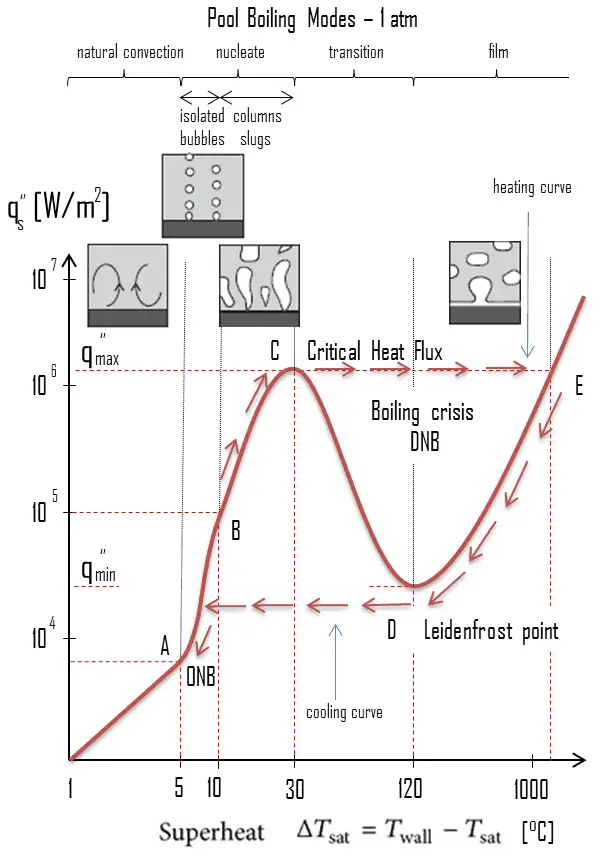

In [1]:
# Import other packages
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
from pyMAISE.datasets import load_chf
from pyMAISE.preprocessing import correlation_matrix, scale_data, read_csv
import pyMAISE as mai
import pyMAISE.explain._explain as explain

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Initialization and Preprocessing

We define a regression problem and load the data using `pyMAISE.datasets.load_chf`. Here, we set `cuda_visible_devices="-1"` to define a CPU-only job as this dataset is reasonably small.

In [ ]:
# Initialize pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Load data
train_data, xtrain, ytrain, test_data, xtest, ytest = load_chf()

The CHF dataset has six inputs listed below with 2500 total samples, 2000 of which are for training.

In [3]:
xtrain

<xarray.DataArray (index: 2000, variable: 6)>
array([[1.01591633e-02, 2.98755621e+00, 1.99910352e+04, 5.20754066e+02,
        2.60238993e+02, 3.36618827e-01],
       [9.61641659e-03, 5.48464942e+00, 7.07735164e+03, 2.74115374e+03,
        2.31174290e+02, 4.12976136e-01],
       [7.58601972e-03, 7.66842472e-01, 1.42533415e+04, 4.03670025e+03,
        2.92868636e+02, 2.48984031e-02],
       ...,
       [8.05556451e-03, 1.03945144e+00, 6.74277013e+03, 2.03124398e+03,
        1.31730956e+02, 1.67113569e-01],
       [1.14979333e-02, 1.78439632e+00, 6.83238523e+03, 1.94423864e+03,
        2.66335292e+02, 3.57005646e-01],
       [7.48060708e-03, 2.97318942e+00, 1.39846734e+04, 4.10568657e+03,
        3.22802524e+02, 2.77580848e-01]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'D (m)' 'L (m)' 'P (kPa)' ... 'Tin (C)' 'Xe (-)'

We have one output, CHF.

In [4]:
ytrain

<xarray.DataArray (index: 2000, variable: 1)>
array([[ 377.05549841],
       [ 956.92913687],
       [3091.19358014],
       ...,
       [3725.37959666],
       [2066.25518823],
       [ 969.10507166]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'CHF (kW m-2)'

Below we have the correlation matrix for this dataset.

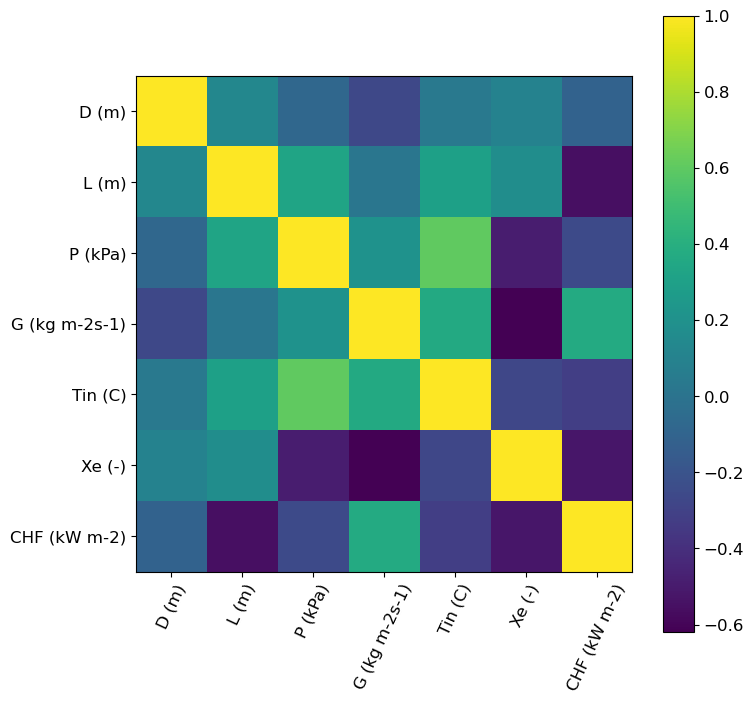

In [5]:
correlation_matrix(xr.concat([train_data, test_data], dim="samples"))
plt.show()

We can see a slightly negative correlation between $L$ and $X$ with $CHF$, while $G$ has a slightly positive correlation.

We then min-max scale all data before hyperparameter tuning.

In [6]:
# Min-max scale data
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 7 regression models:

- linear: ``Linear``,
- lasso: ``lasso``,
- support vector machine ``SVM``,
- decision tree ``DT``,
- random forest ``RF``,
- k-nearest neighbors ``KN``,
- dense feedforward neural networks ``FNN``.

For hyperparameter tuning, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayers, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [7]:
model_settings = {
    "models": ["Linear", "Lasso", "SVM", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=4),
                "units": mai.Int(min_value=25, max_value=300),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([16, 32, 64]),
            "epochs": 30,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

The hyperparameter tuning spaces are defined below. We use random search for the classical models as their training is quick, and random search can cover ample parameter space. Bayesian search is utilized for the FNNs as their training is more computationally expensive. Both search methods use 5-fold cross-validation to mitigate bias from the training data. We train 200 classical models from random search and 50 iterations of Bayesian search for neural networks. 

In [8]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "SVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning neural networks with bayesian search


FNN:   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

After the training, we can see training results for each iteration using the `pyMAISE.Tuner.convergence_plot` function. For the neural networks, we have the following: 

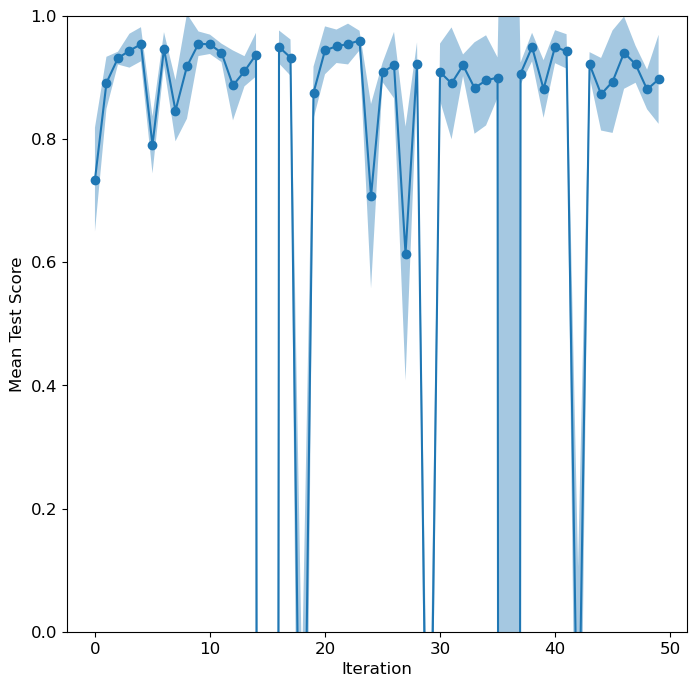

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

The Bayesian search explores the search space but finds several suitable hyperparameter configurations.

## Model Postprocessing

With the top `pyMAISE.Settings.num_configs_saved`, we can pass these parameter configurations to the `pyMAISE.PostProcessor` for model comparison and analysis. For the FNNs, we define the `"epochs"` parameter as 200 for better performance.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

Below we computed the performance metrics based on the performance of each model on the CHF dataset.

In [11]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
30,FNN,0.991139,87.199658,6.040557,136.831535,10.112135,0.985739,106.822002,6.961904,159.078361,9.716554
28,FNN,0.990819,91.240539,6.583316,139.281134,10.808088,0.984041,113.523383,7.612393,168.285319,10.718619
26,FNN,0.983273,136.409465,13.468243,187.999450,22.494870,0.983015,133.938657,12.360601,173.607701,18.839386
29,FNN,0.989919,98.079745,6.171531,145.950210,9.319317,0.981868,117.509279,7.073771,179.375342,9.359211
27,FNN,0.981648,116.528047,6.784139,196.917586,10.596550,0.973365,135.986452,7.554748,217.404081,9.768832
16,RF,0.991889,73.641322,5.160298,130.911772,7.983085,0.961652,174.535521,12.153041,260.862926,17.118159
19,RF,0.978070,117.004479,8.457582,215.260762,14.443851,0.958585,180.807178,12.849989,271.094005,18.742559
18,RF,0.977589,122.362747,8.834362,217.612166,14.756101,0.957667,182.388888,13.021797,274.081755,19.290132
17,RF,0.985075,100.414690,7.154589,177.582982,12.117193,0.957583,184.614299,12.970757,274.353611,18.349557
20,RF,0.977352,116.371649,8.554874,218.755498,14.886697,0.957229,182.667964,12.945912,275.495724,18.971515


This data set is not linear, with a poor performance from linear and lasso regression. The remaining four models in order are FNN > RF > KN > DT > SVM with all five models providing reliable performance. KN overfits with a perfect training $R^2$.

Using the `pyMAISE.PostProcessor.print_model` function, we can see all the top performing (based on test $R^2$) models' hyperparameters.

In [12]:
for model in ["Lasso", "SVM", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00028439653906172225

Model Type: SVM
  degree: 2
  gamma: scale
  kernel: rbf

Model Type: DT
  max_depth: 17
  max_features: None
  min_samples_leaf: 4
  min_samples_split: 7

Model Type: RF
  criterion: poisson
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 3
  n_estimators: 147

Model Type: KN
  leaf_size: 7
  n_neighbors: 5
  p: 1
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 285
      sublayer: None
    Layer: Dense_hidden_1
      units: 239
      sublayer: None
    Layer: Dense_hidden_2
      units: 50
      sublayer: None
    Layer: Dense_hidden_3
      units: 51
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.00043467436247251887
    batch_size: 64
Model: "FNN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 Dense_hidden_0 (Dense)      (None, 285)               1995      


 Dense_hidden_1 (Dense)      (None, 239)               68354     


 Dense_hidden_2 (Dense)      (None, 50)                12000     


 Dense_hidden_3 (Dense)      (None, 51)                2601      


 Dense_output_0 (Dense)      (None, 1)                 52        


Total params: 85,002


Trainable params: 85,002


Non-trainable params: 0


_________________________________________________________________


Below is the network plot for the FNN.

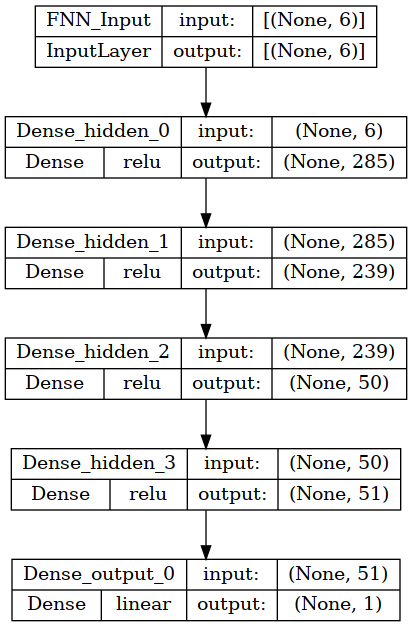

In [13]:
postprocessor.nn_network_plot(
    to_file="./supporting/chf_network.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

We can use the `pyMAISE.PostProcessor.diagonal_validation_plot` and `pyMAISE.PostProcessor.validation_plot` functions to visualize the performance of these models. Diagonal validation plots show the actual versus predicted outcome. A well-performing model follows $y=x$ on this plot. You can choose what outputs to display on the diagonal validation plot; however, since we have a single output (CHF), a single plot will be generated. Both functions use the top-performing model on test $R^2$ by default.

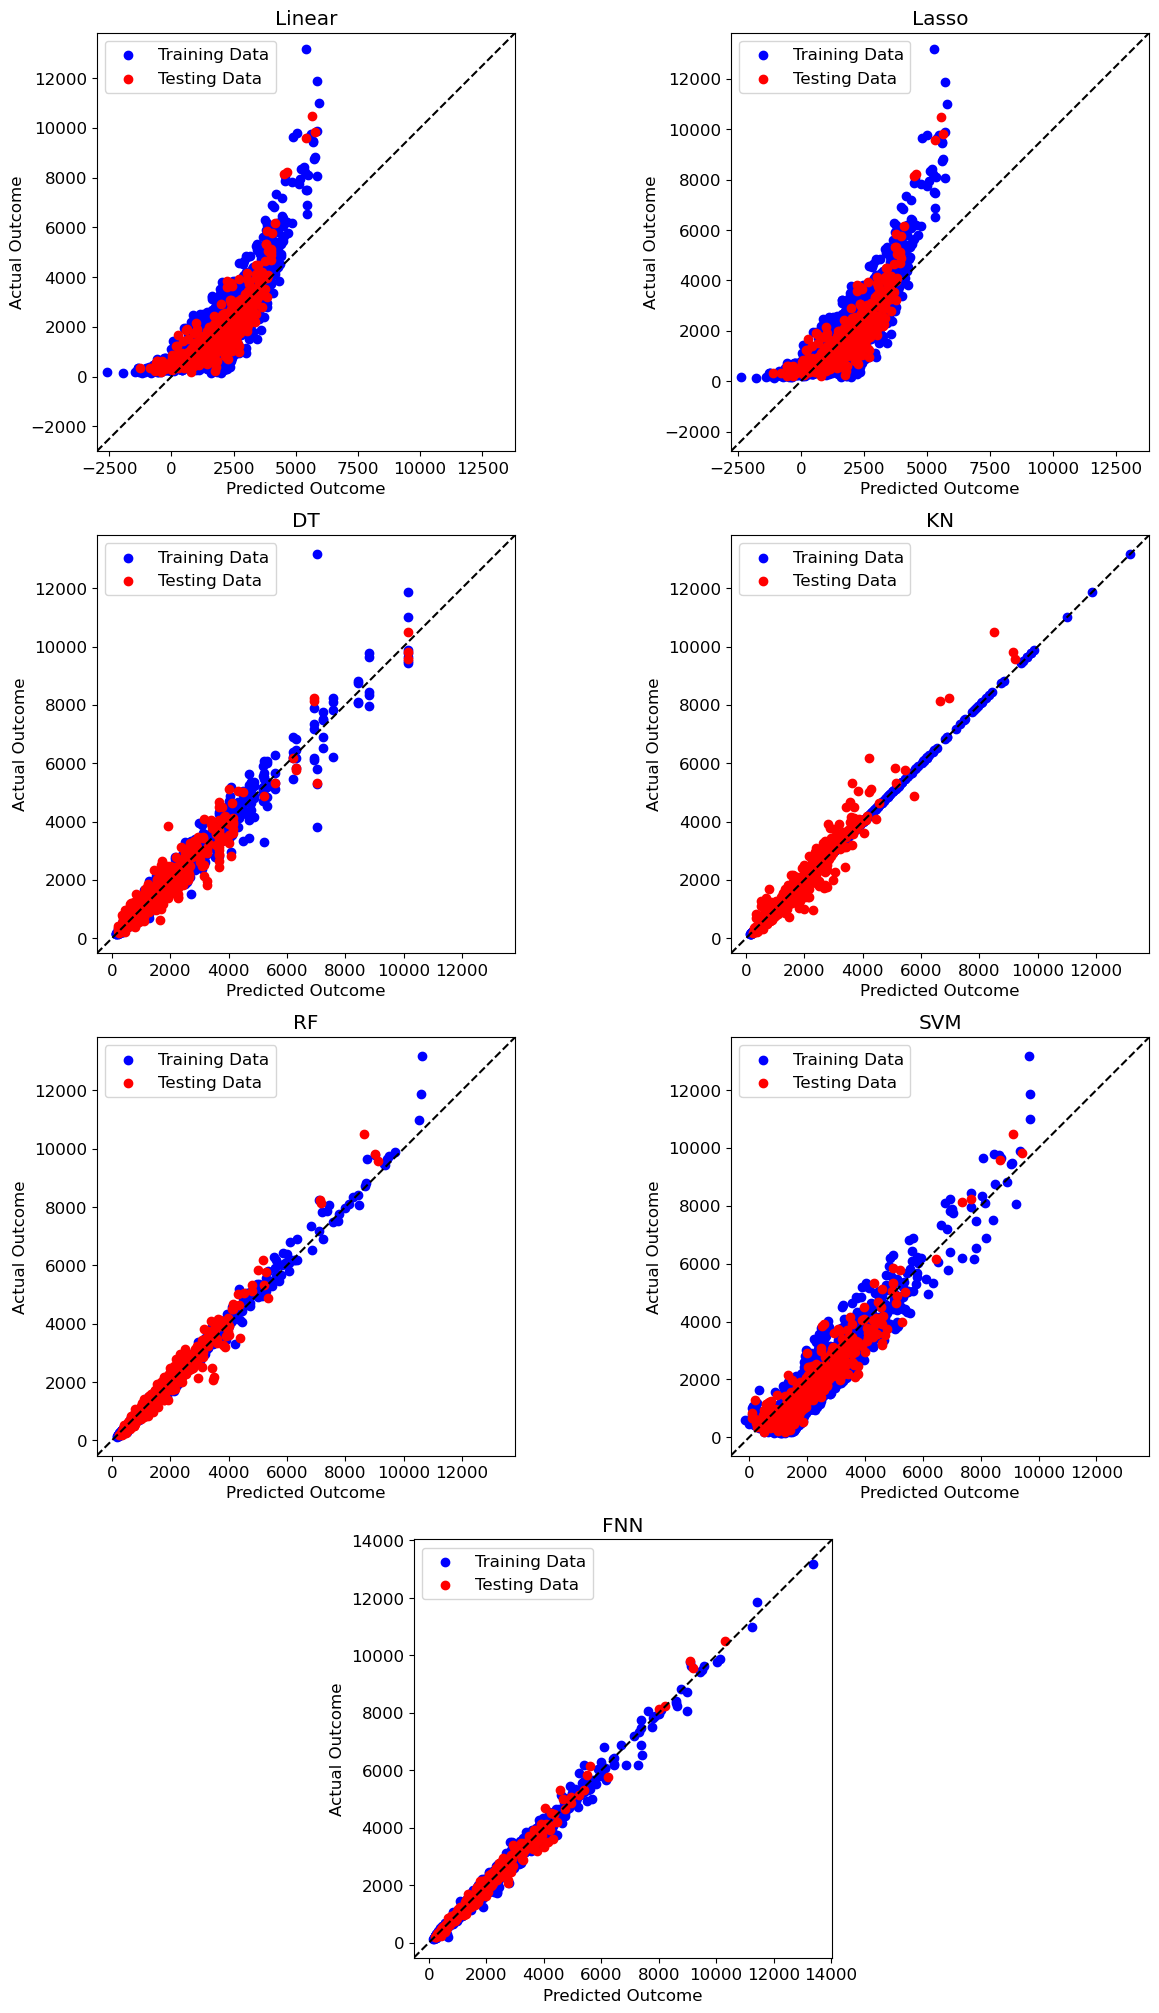

In [14]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "SVM"]])
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

All models display a close spread to $y=x$; however, given the more extensive spread, linear models' lack of performance is apparent.

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set.

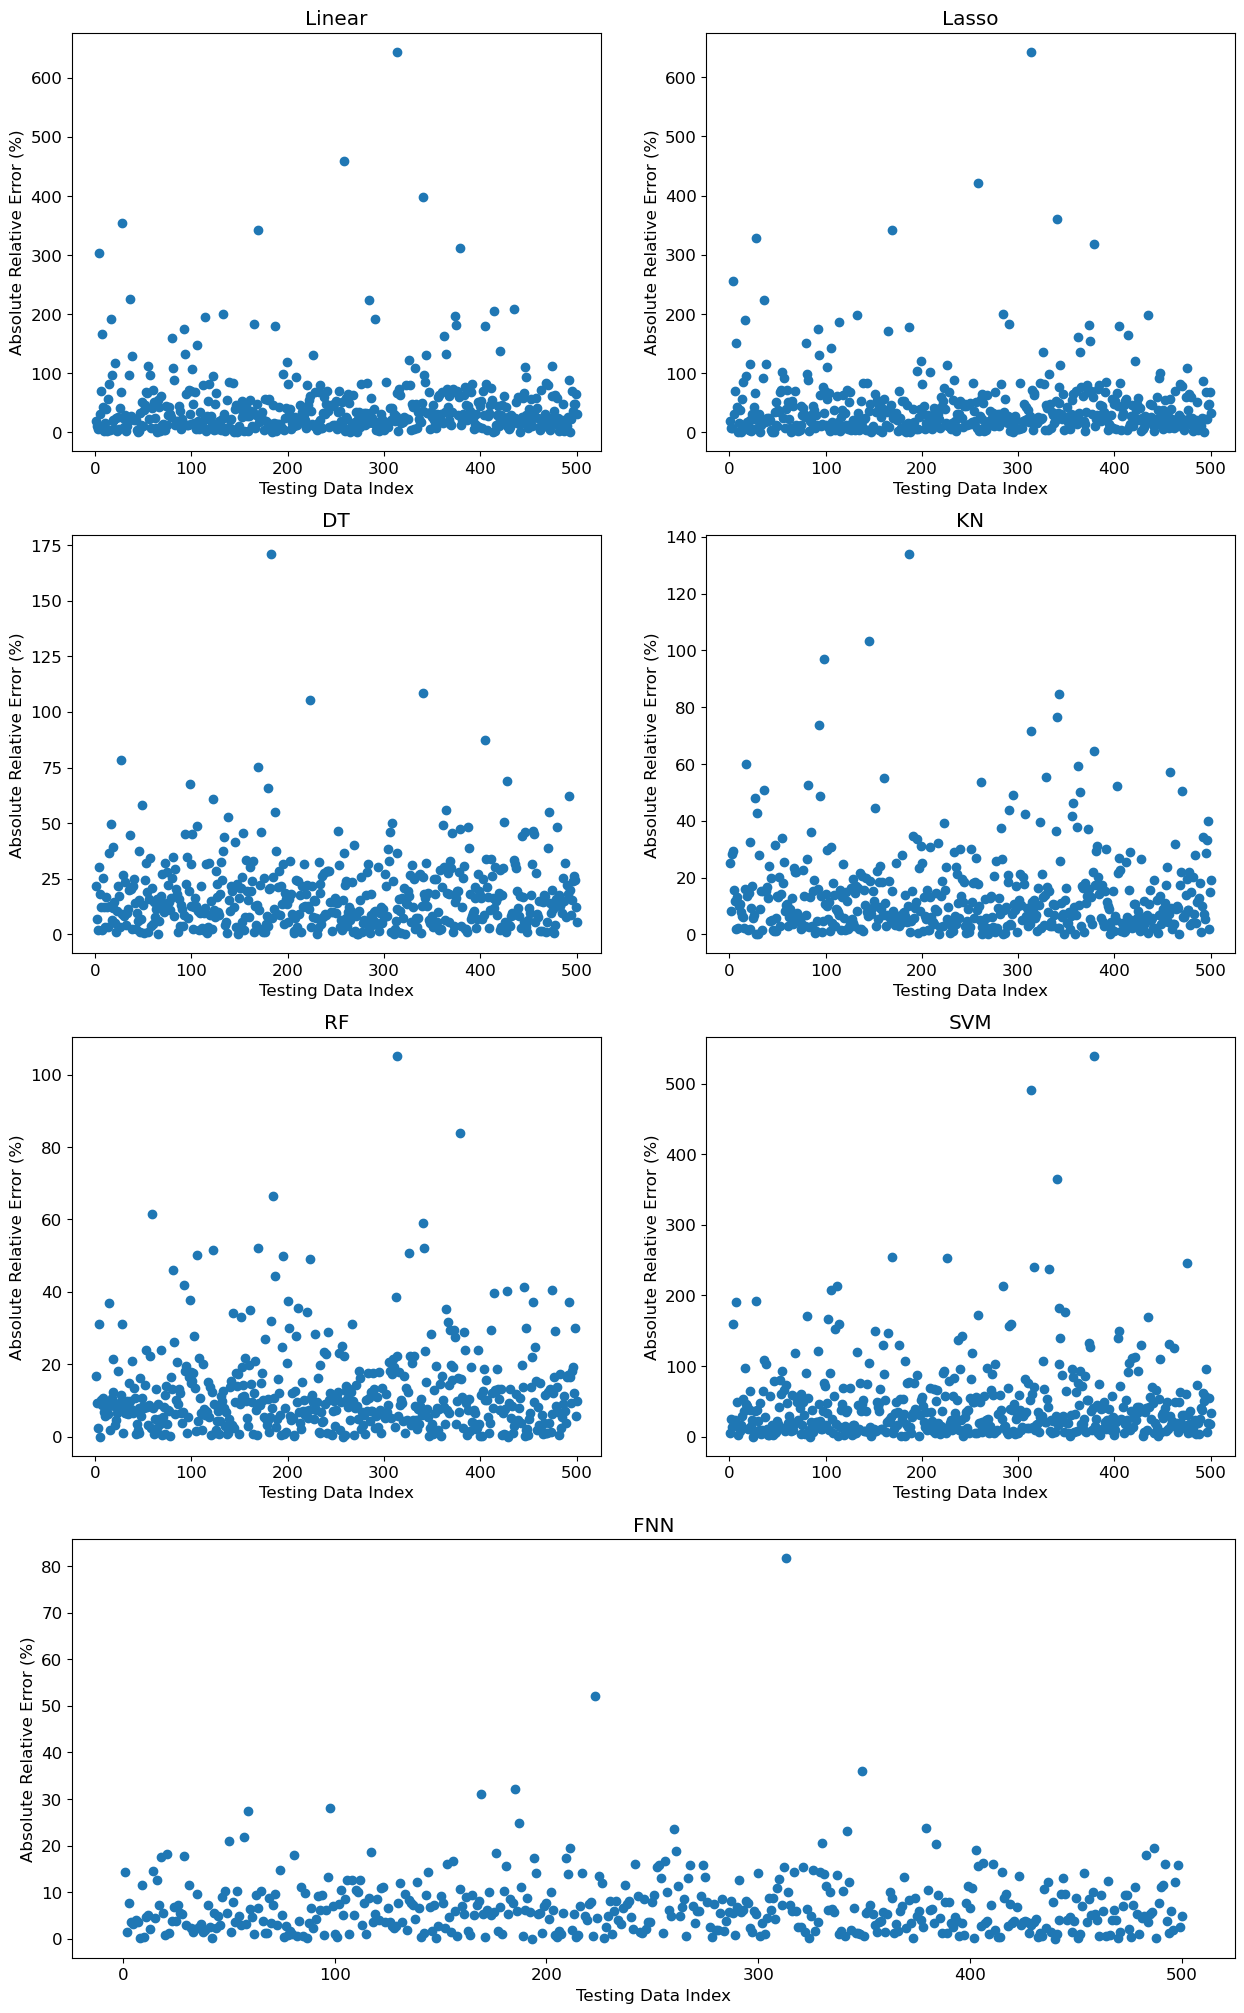

In [15]:
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

Finally, we can see if the FNN is overfit based on its learning curve.

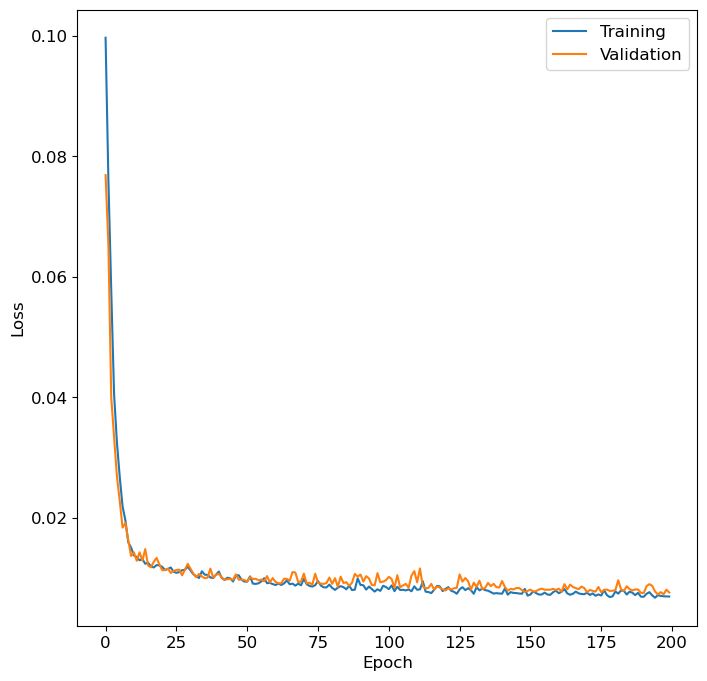

In [16]:
postprocessor.nn_learning_plot()
plt.show()

The FNN is not overfitting, as the validation curve closely follows the training curve.

Finally, using the best FNN model, we can generate new CHF predictions for new experimental setups that do not exist in our data set.

## Explainability Metrics

We start by grabbing our FNN model object and defining our feature and output names to plot in a way that is useful to the analyst. Then, we create an explainability object from our model using those names.

In [17]:
model = postprocessor.get_model(model_type="FNN")

chf_feature_names = [r"$D$ $[m]$", r"$L$ $[m]$", r"$P$ $[kPa]$", r"$G$ $[\frac{kg}{m^2s}]$", r"$T_{In}$ $[^{\circ}C]$", r"$X_e$ $[-]$"]
chf_output_names = [r"$CHF$ $[\frac{kW}{m^2}]$"]

explainer = explain.ShapExplainers(model, X=xtest.values, 
                   feature_names=chf_feature_names, 
                   output_names=chf_output_names)


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 134ms/step


Next, we can use our explainability object, explainer, to call some different SHAP methods. We will use this to produce feature importance rankings for our model. For this scenario, we will try DeepLIFT, KernelSHAP, and Integrated Gradients. The arguments of each of these functions are as follows: <br>
- **DeepLIFT**: nsamples, the default for this value is None, so the method will automatically use all the provided values in X. To select a random subset of samples from X, set nsamples to the length desired. This parameter determines the number of times to re-evaluate the model when explaining each prediction, so maximizing nsamples will minimize variance of the SHAP values.  
- **IntGradients**: nsamples, again, this is the same parameter as DeepLIFT.  
- **KernelSHAP**: this method takes three arguments: n_background_samples, n_test_samples, and n_bootstrap. n_bootstrap is the same as the nsamples parameter from the DeepLIFT and IntGradients methods; it defines the number of times to re-evaluate the model when explaining each prediction. Since KernelSHAP makes local linear approximations to explain model results, it needs some "training" data to fit these local models. These "training" data are defined by the subset of data you provide to the method from index 0 through n_background_samples. Then, to evaluate these local linear approximations, KernelSHAP also needs a "test" set, this is comprised of the data you provide to the method from index n_test_samples to the end of the dataset. Because we generally want to have a higher number of training points than test points, n_background_samples should be greater than n_test_samples. 

In [18]:
explainer.DeepLIFT(nsamples=None)
explainer.IntGradients(nsamples=None)
explainer.KernelSHAP(n_background_samples=200,
             n_test_samples=xtest.values.shape[0] - 200,
             n_bootstrap=200)

/home/npanczyk/pyMAISE/pyMAISE/explain/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/npanczyk/miniconda3/envs/maise/lib/python3.11/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(



1/7 [===>..........................] - ETA: 0s


2/7 [=======>......................] - ETA: 0s


6/7 [========================>.....] - ETA: 0s


7/7 [==============================] - 0s 31ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]


1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 65ms/step



  1/388 [..............................] - ETA: 22s


  4/388 [..............................] - ETA: 6s 


 43/388 [==>...........................] - ETA: 0s


 64/388 [===>..........................] - ETA: 0s


 82/388 [=====>........................] - ETA: 0s


101/388 [======>.......................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


160/388 [===========>..................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 18s


 14/388 [>.............................] - ETA: 1s 


 45/388 [==>...........................] - ETA: 0s


 75/388 [====>.........................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


124/388 [========>.....................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



  1/388 [..............................] - ETA: 26s


 36/388 [=>............................] - ETA: 0s 


 91/388 [======>.......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


228/388 [================>.............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



  1/388 [..............................] - ETA: 17s


 13/388 [>.............................] - ETA: 1s 


 48/388 [==>...........................] - ETA: 0s


 72/388 [====>.........................] - ETA: 0s


 95/388 [======>.......................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



  1/388 [..............................] - ETA: 11s


  4/388 [..............................] - ETA: 6s 


 48/388 [==>...........................] - ETA: 0s


 79/388 [=====>........................] - ETA: 0s


 80/388 [=====>........................] - ETA: 0s


 83/388 [=====>........................] - ETA: 1s


 86/388 [=====>........................] - ETA: 1s


 87/388 [=====>........................] - ETA: 1s


 89/388 [=====>........................] - ETA: 1s


 90/388 [=====>........................] - ETA: 2s


 98/388 [======>.......................] - ETA: 1s


148/388 [==========>...................] - ETA: 1s


190/388 [=============>................] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 14s


 28/388 [=>............................] - ETA: 0s 


 61/388 [===>..........................] - ETA: 0s


 68/388 [====>.........................] - ETA: 0s


 70/388 [====>.........................] - ETA: 1s


 74/388 [====>.........................] - ETA: 1s


 75/388 [====>.........................] - ETA: 1s


 76/388 [====>.........................] - ETA: 1s


 77/388 [====>.........................] - ETA: 2s


 79/388 [=====>........................] - ETA: 2s


136/388 [=========>....................] - ETA: 1s


175/388 [============>.................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


381/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



  1/388 [..............................] - ETA: 32s


  3/388 [..............................] - ETA: 11s


 38/388 [=>............................] - ETA: 1s 


 58/388 [===>..........................] - ETA: 0s


 70/388 [====>.........................] - ETA: 1s


 73/388 [====>.........................] - ETA: 1s


 75/388 [====>.........................] - ETA: 1s


 77/388 [====>.........................] - ETA: 1s


 78/388 [=====>........................] - ETA: 2s


 80/388 [=====>........................] - ETA: 2s


 85/388 [=====>........................] - ETA: 2s


126/388 [========>.....................] - ETA: 1s


148/388 [==========>...................] - ETA: 1s


172/388 [============>.................] - ETA: 1s


205/388 [==============>...............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



  1/388 [..............................] - ETA: 25s


  2/388 [..............................] - ETA: 29s


 24/388 [>.............................] - ETA: 2s 


 33/388 [=>............................] - ETA: 2s


 34/388 [=>............................] - ETA: 3s


 36/388 [=>............................] - ETA: 3s


 38/388 [=>............................] - ETA: 4s


 39/388 [==>...........................] - ETA: 4s


 40/388 [==>...........................] - ETA: 5s


 78/388 [=====>........................] - ETA: 2s


110/388 [=======>......................] - ETA: 1s


134/388 [=========>....................] - ETA: 1s


159/388 [===========>..................] - ETA: 1s


182/388 [=============>................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 86ms/step



  1/388 [..............................] - ETA: 27s


 21/388 [>.............................] - ETA: 1s 


 33/388 [=>............................] - ETA: 1s


 84/388 [=====>........................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


154/388 [==========>...................] - ETA: 0s


184/388 [=============>................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 108ms/step



  1/388 [..............................] - ETA: 43s


  3/388 [..............................] - ETA: 10s


  5/388 [..............................] - ETA: 12s


  7/388 [..............................] - ETA: 11s


  9/388 [..............................] - ETA: 11s


 11/388 [..............................] - ETA: 11s


 17/388 [>.............................] - ETA: 8s 


 65/388 [====>.........................] - ETA: 2s


 86/388 [=====>........................] - ETA: 1s


106/388 [=======>......................] - ETA: 1s


127/388 [========>.....................] - ETA: 1s


147/388 [==========>...................] - ETA: 1s


178/388 [============>.................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 87ms/step



  1/388 [..............................] - ETA: 42s


 28/388 [=>............................] - ETA: 0s 


 54/388 [===>..........................] - ETA: 0s


 73/388 [====>.........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


123/388 [========>.....................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


158/388 [===========>..................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 107ms/step



  1/388 [..............................] - ETA: 36s


  3/388 [..............................] - ETA: 12s


 17/388 [>.............................] - ETA: 2s 


 60/388 [===>..........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 70ms/step



  1/388 [..............................] - ETA: 25s


  6/388 [..............................] - ETA: 5s 


  8/388 [..............................] - ETA: 9s


 10/388 [..............................] - ETA: 10s


 12/388 [..............................] - ETA: 11s


 14/388 [>.............................] - ETA: 11s


 44/388 [==>...........................] - ETA: 3s 


 78/388 [=====>........................] - ETA: 2s


121/388 [========>.....................] - ETA: 1s


150/388 [==========>...................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



  1/388 [..............................] - ETA: 20s


 44/388 [==>...........................] - ETA: 0s 


 97/388 [======>.......................] - ETA: 0s


 99/388 [======>.......................] - ETA: 0s


100/388 [======>.......................] - ETA: 0s


102/388 [======>.......................] - ETA: 0s


104/388 [=======>......................] - ETA: 1s


106/388 [=======>......................] - ETA: 1s


107/388 [=======>......................] - ETA: 1s


108/388 [=======>......................] - ETA: 1s


110/388 [=======>......................] - ETA: 1s


149/388 [==========>...................] - ETA: 1s


202/388 [==============>...............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



  1/388 [..............................] - ETA: 34s


 10/388 [..............................] - ETA: 2s 


 38/388 [=>............................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


244/388 [=================>............] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


308/388 [======================>.......] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 11s


 18/388 [>.............................] - ETA: 1s 


 66/388 [====>.........................] - ETA: 0s


 96/388 [======>.......................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


176/388 [============>.................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 27s


 36/388 [=>............................] - ETA: 0s 


 47/388 [==>...........................] - ETA: 0s


 67/388 [====>.........................] - ETA: 0s


 70/388 [====>.........................] - ETA: 1s


 72/388 [====>.........................] - ETA: 1s


 77/388 [====>.........................] - ETA: 1s


 78/388 [=====>........................] - ETA: 1s


 80/388 [=====>........................] - ETA: 2s


 82/388 [=====>........................] - ETA: 2s


131/388 [=========>....................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


193/388 [=============>................] - ETA: 0s


221/388 [================>.............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


381/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



  1/388 [..............................] - ETA: 22s


 27/388 [=>............................] - ETA: 1s 


 29/388 [=>............................] - ETA: 2s


 31/388 [=>............................] - ETA: 3s


 33/388 [=>............................] - ETA: 3s


 34/388 [=>............................] - ETA: 4s


 35/388 [=>............................] - ETA: 4s


 37/388 [=>............................] - ETA: 5s


 54/388 [===>..........................] - ETA: 3s


108/388 [=======>......................] - ETA: 1s


139/388 [=========>....................] - ETA: 1s


161/388 [===========>..................] - ETA: 1s


185/388 [=============>................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 66ms/step



  1/388 [..............................] - ETA: 24s


 28/388 [=>............................] - ETA: 0s 


 57/388 [===>..........................] - ETA: 0s


 99/388 [======>.......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



  1/388 [..............................] - ETA: 32s


 27/388 [=>............................] - ETA: 0s 


 70/388 [====>.........................] - ETA: 0s


112/388 [=======>......................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 63ms/step



  1/388 [..............................] - ETA: 4s


  3/388 [..............................] - ETA: 9s


 32/388 [=>............................] - ETA: 1s


 52/388 [===>..........................] - ETA: 1s


 72/388 [====>.........................] - ETA: 0s


 96/388 [======>.......................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


215/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 108ms/step



  1/388 [..............................] - ETA: 35s


  2/388 [..............................] - ETA: 21s


  4/388 [..............................] - ETA: 16s


 47/388 [==>...........................] - ETA: 1s 


 82/388 [=====>........................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


221/388 [================>.............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



  1/388 [..............................] - ETA: 7s


  3/388 [..............................] - ETA: 11s


 48/388 [==>...........................] - ETA: 0s 


 69/388 [====>.........................] - ETA: 0s


 73/388 [====>.........................] - ETA: 1s


 75/388 [====>.........................] - ETA: 1s


 76/388 [====>.........................] - ETA: 1s


 77/388 [====>.........................] - ETA: 1s


 78/388 [=====>........................] - ETA: 2s


 79/388 [=====>........................] - ETA: 2s


 81/388 [=====>........................] - ETA: 2s


122/388 [========>.....................] - ETA: 1s


154/388 [==========>...................] - ETA: 1s


175/388 [============>.................] - ETA: 1s


197/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


377/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



  1/388 [..............................] - ETA: 16s


  7/388 [..............................] - ETA: 3s 


 43/388 [==>...........................] - ETA: 0s


 52/388 [===>..........................] - ETA: 1s


 53/388 [===>..........................] - ETA: 1s


 55/388 [===>..........................] - ETA: 1s


 59/388 [===>..........................] - ETA: 2s


 60/388 [===>..........................] - ETA: 2s


 61/388 [===>..........................] - ETA: 2s


 62/388 [===>..........................] - ETA: 2s


 65/388 [====>.........................] - ETA: 3s


111/388 [=======>......................] - ETA: 1s


133/388 [=========>....................] - ETA: 1s


156/388 [===========>..................] - ETA: 1s


203/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


377/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 37s


  3/388 [..............................] - ETA: 13s


 11/388 [..............................] - ETA: 5s 


 13/388 [>.............................] - ETA: 7s


 14/388 [>.............................] - ETA: 8s


 16/388 [>.............................] - ETA: 9s


 18/388 [>.............................] - ETA: 9s


 41/388 [==>...........................] - ETA: 4s


 85/388 [=====>........................] - ETA: 1s


109/388 [=======>......................] - ETA: 1s


138/388 [=========>....................] - ETA: 1s


174/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


374/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



  1/388 [..............................] - ETA: 11s


  4/388 [..............................] - ETA: 6s 


 39/388 [==>...........................] - ETA: 1s


 47/388 [==>...........................] - ETA: 1s


 49/388 [==>...........................] - ETA: 2s


 51/388 [==>...........................] - ETA: 2s


 53/388 [===>..........................] - ETA: 2s


 54/388 [===>..........................] - ETA: 3s


 58/388 [===>..........................] - ETA: 3s


109/388 [=======>......................] - ETA: 1s


134/388 [=========>....................] - ETA: 1s


176/388 [============>.................] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 128ms/step



  1/388 [..............................] - ETA: 39s


 17/388 [>.............................] - ETA: 1s 


 78/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


377/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



  1/388 [..............................] - ETA: 49s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 13s


  7/388 [..............................] - ETA: 10s


  9/388 [..............................] - ETA: 10s


 11/388 [..............................] - ETA: 12s


 12/388 [..............................] - ETA: 12s


 50/388 [==>...........................] - ETA: 2s 


 81/388 [=====>........................] - ETA: 1s


105/388 [=======>......................] - ETA: 1s


130/388 [=========>....................] - ETA: 1s


151/388 [==========>...................] - ETA: 1s


175/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



  1/388 [..............................] - ETA: 13s


  7/388 [..............................] - ETA: 3s 


 56/388 [===>..........................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



  1/388 [..............................] - ETA: 19s


 11/388 [..............................] - ETA: 1s 


 58/388 [===>..........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



  1/388 [..............................] - ETA: 16s


  3/388 [..............................] - ETA: 10s


 49/388 [==>...........................] - ETA: 0s 


 78/388 [=====>........................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


154/388 [==========>...................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


164/388 [===========>..................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


168/388 [===========>..................] - ETA: 1s


208/388 [===============>..............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


381/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



  1/388 [..............................] - ETA: 17s


  3/388 [..............................] - ETA: 17s


  5/388 [..............................] - ETA: 15s


  7/388 [..............................] - ETA: 14s


  9/388 [..............................] - ETA: 15s


 11/388 [..............................] - ETA: 15s


 13/388 [>.............................] - ETA: 15s


 29/388 [=>............................] - ETA: 6s 


 81/388 [=====>........................] - ETA: 2s


121/388 [========>.....................] - ETA: 1s


166/388 [===========>..................] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 63ms/step



  1/388 [..............................] - ETA: 55s


  3/388 [..............................] - ETA: 14s


  4/388 [..............................] - ETA: 17s


 29/388 [=>............................] - ETA: 2s 


 54/388 [===>..........................] - ETA: 1s


 72/388 [====>.........................] - ETA: 1s


 95/388 [======>.......................] - ETA: 1s


120/388 [========>.....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 101ms/step



  1/388 [..............................] - ETA: 12s


 29/388 [=>............................] - ETA: 0s 


 56/388 [===>..........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


152/388 [==========>...................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



  1/388 [..............................] - ETA: 16s


  3/388 [..............................] - ETA: 10s


 49/388 [==>...........................] - ETA: 0s 


 89/388 [=====>........................] - ETA: 0s


131/388 [=========>....................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 6s


  4/388 [..............................] - ETA: 6s


 56/388 [===>..........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


139/388 [=========>....................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 27s


 15/388 [>.............................] - ETA: 1s 


 68/388 [====>.........................] - ETA: 0s


 82/388 [=====>........................] - ETA: 0s


 84/388 [=====>........................] - ETA: 0s


 86/388 [=====>........................] - ETA: 1s


 88/388 [=====>........................] - ETA: 1s


 89/388 [=====>........................] - ETA: 1s


 90/388 [=====>........................] - ETA: 1s


 91/388 [======>.......................] - ETA: 2s


135/388 [=========>....................] - ETA: 1s


186/388 [=============>................] - ETA: 0s


232/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 56s


  2/388 [..............................] - ETA: 21s


  4/388 [..............................] - ETA: 14s


 41/388 [==>...........................] - ETA: 1s 


 76/388 [====>.........................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


132/388 [=========>....................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 90ms/step



  1/388 [..............................] - ETA: 36s


  2/388 [..............................] - ETA: 23s


  4/388 [..............................] - ETA: 20s


 15/388 [>.............................] - ETA: 5s 


 47/388 [==>...........................] - ETA: 1s


 75/388 [====>.........................] - ETA: 1s


107/388 [=======>......................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


182/388 [=============>................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


227/388 [================>.............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 6s


 18/388 [>.............................] - ETA: 1s


 45/388 [==>...........................] - ETA: 0s


 70/388 [====>.........................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


308/388 [======================>.......] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



  1/388 [..............................] - ETA: 29s


 47/388 [==>...........................] - ETA: 0s 


 84/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


135/388 [=========>....................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 31s


 43/388 [==>...........................] - ETA: 0s 


 74/388 [====>.........................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



  1/388 [..............................] - ETA: 24s


 38/388 [=>............................] - ETA: 0s 


 71/388 [====>.........................] - ETA: 0s


 85/388 [=====>........................] - ETA: 0s


 93/388 [======>.......................] - ETA: 0s


 98/388 [======>.......................] - ETA: 1s


100/388 [======>.......................] - ETA: 1s


102/388 [======>.......................] - ETA: 1s


104/388 [=======>......................] - ETA: 1s


145/388 [==========>...................] - ETA: 1s


180/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



  1/388 [..............................] - ETA: 35s


  3/388 [..............................] - ETA: 13s


  5/388 [..............................] - ETA: 15s


  7/388 [..............................] - ETA: 16s


  9/388 [..............................] - ETA: 17s


 10/388 [..............................] - ETA: 17s


 11/388 [..............................] - ETA: 18s


 31/388 [=>............................] - ETA: 6s 


 88/388 [=====>........................] - ETA: 2s


121/388 [========>.....................] - ETA: 1s


154/388 [==========>...................] - ETA: 1s


172/388 [============>.................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 95ms/step



  1/388 [..............................] - ETA: 18s


 22/388 [>.............................] - ETA: 0s 


 44/388 [==>...........................] - ETA: 0s


 65/388 [====>.........................] - ETA: 0s


 92/388 [======>.......................] - ETA: 0s


118/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 75ms/step



  1/388 [..............................] - ETA: 10s


 26/388 [=>............................] - ETA: 0s 


 57/388 [===>..........................] - ETA: 0s


 87/388 [=====>........................] - ETA: 0s


115/388 [=======>......................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


381/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



  1/388 [..............................] - ETA: 33s


  3/388 [..............................] - ETA: 10s


 50/388 [==>...........................] - ETA: 0s 


103/388 [======>.......................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 21s


 12/388 [..............................] - ETA: 1s 


 51/388 [==>...........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


123/388 [========>.....................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 80ms/step



  1/388 [..............................] - ETA: 28s


  2/388 [..............................] - ETA: 37s


  4/388 [..............................] - ETA: 22s


  5/388 [..............................] - ETA: 22s


 34/388 [=>............................] - ETA: 3s 


 59/388 [===>..........................] - ETA: 1s


114/388 [=======>......................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


225/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 95ms/step



  1/388 [..............................] - ETA: 20s


 13/388 [>.............................] - ETA: 1s 


 51/388 [==>...........................] - ETA: 0s


 80/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


208/388 [===============>..............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



  1/388 [..............................] - ETA: 45s


  3/388 [..............................] - ETA: 11s


  6/388 [..............................] - ETA: 8s 


  8/388 [..............................] - ETA: 9s


 12/388 [..............................] - ETA: 8s


 14/388 [>.............................] - ETA: 9s


 16/388 [>.............................] - ETA: 9s


 65/388 [====>.........................] - ETA: 2s


 93/388 [======>.......................] - ETA: 1s


117/388 [========>.....................] - ETA: 1s


141/388 [=========>....................] - ETA: 1s


166/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 90ms/step



  1/388 [..............................] - ETA: 30s


  3/388 [..............................] - ETA: 13s


 24/388 [>.............................] - ETA: 1s 


 80/388 [=====>........................] - ETA: 0s


112/388 [=======>......................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



  1/388 [..............................] - ETA: 29s


 24/388 [>.............................] - ETA: 0s 


 49/388 [==>...........................] - ETA: 0s


 73/388 [====>.........................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


122/388 [========>.....................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


215/388 [===============>..............] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



  1/388 [..............................] - ETA: 8s


  6/388 [..............................] - ETA: 3s


 55/388 [===>..........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


158/388 [===========>..................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 122ms/step



  1/388 [..............................] - ETA: 40s


  2/388 [..............................] - ETA: 27s


  5/388 [..............................] - ETA: 12s


 40/388 [==>...........................] - ETA: 1s 


 73/388 [====>.........................] - ETA: 1s


 97/388 [======>.......................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


182/388 [=============>................] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 115ms/step



  1/388 [..............................] - ETA: 36s


  2/388 [..............................] - ETA: 22s


 19/388 [>.............................] - ETA: 2s 


 78/388 [=====>........................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


222/388 [================>.............] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



  1/388 [..............................] - ETA: 24s


 32/388 [=>............................] - ETA: 0s 


 68/388 [====>.........................] - ETA: 0s


 70/388 [====>.........................] - ETA: 0s


 84/388 [=====>........................] - ETA: 0s


 86/388 [=====>........................] - ETA: 1s


 88/388 [=====>........................] - ETA: 1s


 90/388 [=====>........................] - ETA: 1s


 92/388 [======>.......................] - ETA: 1s


 93/388 [======>.......................] - ETA: 1s


 99/388 [======>.......................] - ETA: 1s


153/388 [==========>...................] - ETA: 1s


192/388 [=============>................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


382/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



  1/388 [..............................] - ETA: 22s


  4/388 [..............................] - ETA: 7s 


 52/388 [===>..........................] - ETA: 0s


 79/388 [=====>........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



  1/388 [..............................] - ETA: 22s


  4/388 [..............................] - ETA: 6s 


 26/388 [=>............................] - ETA: 1s


 46/388 [==>...........................] - ETA: 1s


 53/388 [===>..........................] - ETA: 1s


 59/388 [===>..........................] - ETA: 1s


 61/388 [===>..........................] - ETA: 1s


 72/388 [====>.........................] - ETA: 1s


 75/388 [====>.........................] - ETA: 1s


 76/388 [====>.........................] - ETA: 2s


 80/388 [=====>........................] - ETA: 2s


121/388 [========>.....................] - ETA: 1s


148/388 [==========>...................] - ETA: 1s


168/388 [===========>..................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



  1/388 [..............................] - ETA: 15s


 47/388 [==>...........................] - ETA: 0s 


 95/388 [======>.......................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


227/388 [================>.............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 14s


  2/388 [..............................] - ETA: 24s


  4/388 [..............................] - ETA: 14s


 16/388 [>.............................] - ETA: 4s 


 18/388 [>.............................] - ETA: 5s


 20/388 [>.............................] - ETA: 6s


 22/388 [>.............................] - ETA: 7s


 24/388 [>.............................] - ETA: 7s


 34/388 [=>............................] - ETA: 5s


 81/388 [=====>........................] - ETA: 2s


120/388 [========>.....................] - ETA: 1s


157/388 [===========>..................] - ETA: 1s


185/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



  1/388 [..............................] - ETA: 16s


  9/388 [..............................] - ETA: 2s 


 42/388 [==>...........................] - ETA: 0s


 54/388 [===>..........................] - ETA: 1s


 60/388 [===>..........................] - ETA: 1s


 62/388 [===>..........................] - ETA: 1s


 63/388 [===>..........................] - ETA: 2s


 64/388 [===>..........................] - ETA: 2s


 65/388 [====>.........................] - ETA: 2s


 66/388 [====>.........................] - ETA: 2s


 68/388 [====>.........................] - ETA: 3s


112/388 [=======>......................] - ETA: 1s


139/388 [=========>....................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


192/388 [=============>................] - ETA: 0s


222/388 [================>.............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 11ms/step



  1/388 [..............................] - ETA: 48s


  4/388 [..............................] - ETA: 6s 


 10/388 [..............................] - ETA: 4s


 12/388 [..............................] - ETA: 6s


 14/388 [>.............................] - ETA: 8s


 16/388 [>.............................] - ETA: 8s


 55/388 [===>..........................] - ETA: 2s


 72/388 [====>.........................] - ETA: 1s


 95/388 [======>.......................] - ETA: 1s


115/388 [=======>......................] - ETA: 1s


138/388 [=========>....................] - ETA: 1s


161/388 [===========>..................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 123ms/step



  1/388 [..............................] - ETA: 16s


 27/388 [=>............................] - ETA: 0s 


 76/388 [====>.........................] - ETA: 0s


110/388 [=======>......................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



  1/388 [..............................] - ETA: 16s


 24/388 [>.............................] - ETA: 0s 


 48/388 [==>...........................] - ETA: 0s


 72/388 [====>.........................] - ETA: 0s


 90/388 [=====>........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


124/388 [========>.....................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


139/388 [=========>....................] - ETA: 1s


140/388 [=========>....................] - ETA: 1s


142/388 [=========>....................] - ETA: 1s


144/388 [==========>...................] - ETA: 1s


146/388 [==========>...................] - ETA: 1s


189/388 [=============>................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 18s


  3/388 [..............................] - ETA: 12s


  5/388 [..............................] - ETA: 13s


  8/388 [..............................] - ETA: 10s


 11/388 [..............................] - ETA: 9s 


 12/388 [..............................] - ETA: 10s


 14/388 [>.............................] - ETA: 10s


 16/388 [>.............................] - ETA: 11s


 43/388 [==>...........................] - ETA: 4s 


 73/388 [====>.........................] - ETA: 2s


 95/388 [======>.......................] - ETA: 1s


115/388 [=======>......................] - ETA: 1s


137/388 [=========>....................] - ETA: 1s


166/388 [===========>..................] - ETA: 1s


189/388 [=============>................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



  1/388 [..............................] - ETA: 23s


 15/388 [>.............................] - ETA: 1s 


 42/388 [==>...........................] - ETA: 0s


 64/388 [===>..........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 0s


116/388 [=======>......................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


208/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



  1/388 [..............................] - ETA: 9s


 28/388 [=>............................] - ETA: 0s


 60/388 [===>..........................] - ETA: 0s


100/388 [======>.......................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 56s


  3/388 [..............................] - ETA: 15s


  7/388 [..............................] - ETA: 9s 


  8/388 [..............................] - ETA: 10s


 10/388 [..............................] - ETA: 12s


 12/388 [..............................] - ETA: 12s


 56/388 [===>..........................] - ETA: 2s 


 80/388 [=====>........................] - ETA: 1s


105/388 [=======>......................] - ETA: 1s


129/388 [========>.....................] - ETA: 1s


148/388 [==========>...................] - ETA: 1s


167/388 [===========>..................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 15s


 20/388 [>.............................] - ETA: 1s 


 55/388 [===>..........................] - ETA: 0s


 80/388 [=====>........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


151/388 [==========>...................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 93ms/step



  1/388 [..............................] - ETA: 27s


  2/388 [..............................] - ETA: 20s


  3/388 [..............................] - ETA: 20s


  6/388 [..............................] - ETA: 12s


 53/388 [===>..........................] - ETA: 1s 


 99/388 [======>.......................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


185/388 [=============>................] - ETA: 0s


220/388 [================>.............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 13s


  7/388 [..............................] - ETA: 3s 


 62/388 [===>..........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


244/388 [=================>............] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 93ms/step



  1/388 [..............................] - ETA: 6s


  5/388 [..............................] - ETA: 4s


 25/388 [>.............................] - ETA: 1s


 62/388 [===>..........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 92ms/step



  1/388 [..............................] - ETA: 37s


 19/388 [>.............................] - ETA: 1s 


 55/388 [===>..........................] - ETA: 0s


 78/388 [=====>........................] - ETA: 0s


 98/388 [======>.......................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 11s


 30/388 [=>............................] - ETA: 0s 


 66/388 [====>.........................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 17s


  3/388 [..............................] - ETA: 9s 


 21/388 [>.............................] - ETA: 1s


 39/388 [==>...........................] - ETA: 1s


 60/388 [===>..........................] - ETA: 1s


 80/388 [=====>........................] - ETA: 1s


 98/388 [======>.......................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 6s


  4/388 [..............................] - ETA: 6s


 54/388 [===>..........................] - ETA: 0s


 87/388 [=====>........................] - ETA: 0s


116/388 [=======>......................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 86ms/step



  1/388 [..............................] - ETA: 29s


  3/388 [..............................] - ETA: 10s


 45/388 [==>...........................] - ETA: 1s 


 53/388 [===>..........................] - ETA: 1s


 55/388 [===>..........................] - ETA: 1s


 57/388 [===>..........................] - ETA: 2s


 58/388 [===>..........................] - ETA: 2s


 59/388 [===>..........................] - ETA: 2s


 61/388 [===>..........................] - ETA: 3s


 63/388 [===>..........................] - ETA: 3s


 64/388 [===>..........................] - ETA: 3s


 65/388 [====>.........................] - ETA: 3s


 81/388 [=====>........................] - ETA: 3s


141/388 [=========>....................] - ETA: 1s


175/388 [============>.................] - ETA: 1s


215/388 [===============>..............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 10s


  7/388 [..............................] - ETA: 6s 


  8/388 [..............................] - ETA: 8s


  9/388 [..............................] - ETA: 10s


 10/388 [..............................] - ETA: 12s


 11/388 [..............................] - ETA: 13s


 12/388 [..............................] - ETA: 14s


 14/388 [>.............................] - ETA: 13s


 15/388 [>.............................] - ETA: 14s


 16/388 [>.............................] - ETA: 15s


 17/388 [>.............................] - ETA: 15s


 60/388 [===>..........................] - ETA: 4s 


100/388 [======>.......................] - ETA: 2s


118/388 [========>.....................] - ETA: 1s


138/388 [=========>....................] - ETA: 1s


158/388 [===========>..................] - ETA: 1s


177/388 [============>.................] - ETA: 1s


195/388 [==============>...............] - ETA: 1s


215/388 [===============>..............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



  1/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 7s 


 42/388 [==>...........................] - ETA: 0s


 65/388 [====>.........................] - ETA: 0s


 92/388 [======>.......................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


131/388 [=========>....................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


144/388 [==========>...................] - ETA: 1s


146/388 [==========>...................] - ETA: 1s


148/388 [==========>...................] - ETA: 1s


190/388 [=============>................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


215/388 [===============>..............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


224/388 [================>.............] - ETA: 1s


226/388 [================>.............] - ETA: 1s


228/388 [================>.............] - ETA: 1s


230/388 [================>.............] - ETA: 1s


263/388 [===================>..........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 11ms/step



  1/388 [..............................] - ETA: 9s


 23/388 [>.............................] - ETA: 0s


 54/388 [===>..........................] - ETA: 0s


 90/388 [=====>........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



  1/388 [..............................] - ETA: 31s


 28/388 [=>............................] - ETA: 0s 


 66/388 [====>.........................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


114/388 [=======>......................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 30s


 32/388 [=>............................] - ETA: 0s 


 59/388 [===>..........................] - ETA: 0s


 86/388 [=====>........................] - ETA: 0s


116/388 [=======>......................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



  1/388 [..............................] - ETA: 18s


 21/388 [>.............................] - ETA: 0s 


 57/388 [===>..........................] - ETA: 0s


 83/388 [=====>........................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 6s


  2/388 [..............................] - ETA: 19s


 43/388 [==>...........................] - ETA: 0s 


 96/388 [======>.......................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 5s


  2/388 [..............................] - ETA: 19s


 51/388 [==>...........................] - ETA: 0s 


 92/388 [======>.......................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


108/388 [=======>......................] - ETA: 1s


109/388 [=======>......................] - ETA: 1s


110/388 [=======>......................] - ETA: 1s


111/388 [=======>......................] - ETA: 1s


113/388 [=======>......................] - ETA: 1s


168/388 [===========>..................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


237/388 [=================>............] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



  1/388 [..............................] - ETA: 14s


  2/388 [..............................] - ETA: 26s


 48/388 [==>...........................] - ETA: 0s 


 74/388 [====>.........................] - ETA: 0s


 98/388 [======>.......................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


179/388 [============>.................] - ETA: 1s


229/388 [================>.............] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



  1/388 [..............................] - ETA: 11s


  6/388 [..............................] - ETA: 3s 


 51/388 [==>...........................] - ETA: 0s


 86/388 [=====>........................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


124/388 [========>.....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



  1/388 [..............................] - ETA: 15s


  2/388 [..............................] - ETA: 21s


 56/388 [===>..........................] - ETA: 0s 


 97/388 [======>.......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


232/388 [================>.............] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



  1/388 [..............................] - ETA: 18s


 22/388 [>.............................] - ETA: 0s 


 78/388 [=====>........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 5s


  2/388 [..............................] - ETA: 31s


  5/388 [..............................] - ETA: 14s


  6/388 [..............................] - ETA: 15s


  8/388 [..............................] - ETA: 15s


 10/388 [..............................] - ETA: 15s


 11/388 [..............................] - ETA: 16s


 13/388 [>.............................] - ETA: 15s


 63/388 [===>..........................] - ETA: 2s 


100/388 [======>.......................] - ETA: 1s


130/388 [=========>....................] - ETA: 1s


177/388 [============>.................] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 73ms/step



  1/388 [..............................] - ETA: 9s


  7/388 [..............................] - ETA: 3s


 41/388 [==>...........................] - ETA: 1s


 42/388 [==>...........................] - ETA: 1s


 44/388 [==>...........................] - ETA: 2s


 45/388 [==>...........................] - ETA: 2s


 46/388 [==>...........................] - ETA: 3s


 47/388 [==>...........................] - ETA: 3s


 49/388 [==>...........................] - ETA: 3s


 88/388 [=====>........................] - ETA: 1s


125/388 [========>.....................] - ETA: 1s


159/388 [===========>..................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



  1/388 [..............................] - ETA: 19s


  2/388 [..............................] - ETA: 29s


  8/388 [..............................] - ETA: 9s 


 10/388 [..............................] - ETA: 10s


 12/388 [..............................] - ETA: 12s


 13/388 [>.............................] - ETA: 12s


 14/388 [>.............................] - ETA: 13s


 16/388 [>.............................] - ETA: 12s


 63/388 [===>..........................] - ETA: 2s 


 89/388 [=====>........................] - ETA: 2s


113/388 [=======>......................] - ETA: 1s


137/388 [=========>....................] - ETA: 1s


161/388 [===========>..................] - ETA: 1s


185/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 90ms/step



  1/388 [..............................] - ETA: 21s


  3/388 [..............................] - ETA: 9s 


 56/388 [===>..........................] - ETA: 0s


 81/388 [=====>........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


130/388 [=========>....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



  1/388 [..............................] - ETA: 18s


 35/388 [=>............................] - ETA: 0s 


 83/388 [=====>........................] - ETA: 0s


127/388 [========>.....................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 14s


  4/388 [..............................] - ETA: 8s 


 39/388 [==>...........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 0s


 92/388 [======>.......................] - ETA: 0s


118/388 [========>.....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


308/388 [======================>.......] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 17s


 32/388 [=>............................] - ETA: 0s 


 87/388 [=====>........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



  1/388 [..............................] - ETA: 35s


 22/388 [>.............................] - ETA: 0s 


 68/388 [====>.........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



  1/388 [..............................] - ETA: 16s


 38/388 [=>............................] - ETA: 0s 


 89/388 [=====>........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


184/388 [=============>................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 8s


 14/388 [>.............................] - ETA: 1s


 51/388 [==>...........................] - ETA: 0s


 71/388 [====>.........................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 27s


 27/388 [=>............................] - ETA: 0s 


 59/388 [===>..........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


164/388 [===========>..................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


241/388 [=================>............] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 28s


 18/388 [>.............................] - ETA: 1s 


 68/388 [====>.........................] - ETA: 0s


101/388 [======>.......................] - ETA: 0s


131/388 [=========>....................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


227/388 [================>.............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 10s


  3/388 [..............................] - ETA: 9s 


 40/388 [==>...........................] - ETA: 0s


 87/388 [=====>........................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


237/388 [=================>............] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 94ms/step



  1/388 [..............................] - ETA: 36s


  2/388 [..............................] - ETA: 33s


  4/388 [..............................] - ETA: 21s


 32/388 [=>............................] - ETA: 2s 


 94/388 [======>.......................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 91ms/step



  1/388 [..............................] - ETA: 25s


  2/388 [..............................] - ETA: 21s


 25/388 [>.............................] - ETA: 1s 


 58/388 [===>..........................] - ETA: 0s


 85/388 [=====>........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


127/388 [========>.....................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 24s


  7/388 [..............................] - ETA: 3s 


 48/388 [==>...........................] - ETA: 0s


 83/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



  1/388 [..............................] - ETA: 17s


  4/388 [..............................] - ETA: 6s 


 46/388 [==>...........................] - ETA: 0s


 73/388 [====>.........................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 75ms/step



  1/388 [..............................] - ETA: 14s


  9/388 [..............................] - ETA: 2s 


 35/388 [=>............................] - ETA: 1s


 62/388 [===>..........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


114/388 [=======>......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 12s


  3/388 [..............................] - ETA: 9s 


 50/388 [==>...........................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


378/388 [============================>.] - ETA: 0s


379/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



  1/388 [..............................] - ETA: 20s


 47/388 [==>...........................] - ETA: 0s 


 79/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



  1/388 [..............................] - ETA: 13s


  5/388 [..............................] - ETA: 4s 


 50/388 [==>...........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 0s


123/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


158/388 [===========>..................] - ETA: 0s


160/388 [===========>..................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


242/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 107ms/step



  1/388 [..............................] - ETA: 30s


  4/388 [..............................] - ETA: 10s


  5/388 [..............................] - ETA: 12s


  7/388 [..............................] - ETA: 14s


 46/388 [==>...........................] - ETA: 2s 


 93/388 [======>.......................] - ETA: 1s


114/388 [=======>......................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 101ms/step



  1/388 [..............................] - ETA: 40s


  3/388 [..............................] - ETA: 12s


  5/388 [..............................] - ETA: 12s


 29/388 [=>............................] - ETA: 2s 


 71/388 [====>.........................] - ETA: 1s


 97/388 [======>.......................] - ETA: 0s


122/388 [========>.....................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 33s


  3/388 [..............................] - ETA: 11s


 38/388 [=>............................] - ETA: 1s 


 85/388 [=====>........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 97ms/step



  1/388 [..............................] - ETA: 36s


 20/388 [>.............................] - ETA: 0s 


 45/388 [==>...........................] - ETA: 0s


 69/388 [====>.........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


118/388 [========>.....................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


165/388 [===========>..................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 10s


  3/388 [..............................] - ETA: 10s


 45/388 [==>...........................] - ETA: 0s 


 96/388 [======>.......................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



  1/388 [..............................] - ETA: 9s


 43/388 [==>...........................] - ETA: 0s


 76/388 [====>.........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


154/388 [==========>...................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 116ms/step



  1/388 [..............................] - ETA: 35s


  2/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 27s


  5/388 [..............................] - ETA: 19s


 48/388 [==>...........................] - ETA: 1s 


 65/388 [====>.........................] - ETA: 1s


 82/388 [=====>........................] - ETA: 1s


104/388 [=======>......................] - ETA: 1s


122/388 [========>.....................] - ETA: 1s


132/388 [=========>....................] - ETA: 1s


150/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 112ms/step



  1/388 [..............................] - ETA: 13s


 25/388 [>.............................] - ETA: 0s 


 66/388 [====>.........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


139/388 [=========>....................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 23s


 22/388 [>.............................] - ETA: 0s 


 52/388 [===>..........................] - ETA: 0s


 75/388 [====>.........................] - ETA: 0s


 95/388 [======>.......................] - ETA: 0s


116/388 [=======>......................] - ETA: 0s


124/388 [========>.....................] - ETA: 0s


126/388 [========>.....................] - ETA: 0s


127/388 [========>.....................] - ETA: 0s


128/388 [========>.....................] - ETA: 1s


129/388 [========>.....................] - ETA: 1s


130/388 [=========>....................] - ETA: 1s


131/388 [=========>....................] - ETA: 1s


183/388 [=============>................] - ETA: 0s


226/388 [================>.............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 103ms/step



  1/388 [..............................] - ETA: 33s


  2/388 [..............................] - ETA: 20s


  3/388 [..............................] - ETA: 21s


  4/388 [..............................] - ETA: 21s


 17/388 [>.............................] - ETA: 5s 


 78/388 [=====>........................] - ETA: 1s


122/388 [========>.....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


377/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 60ms/step



  1/388 [..............................] - ETA: 25s


 21/388 [>.............................] - ETA: 0s 


 66/388 [====>.........................] - ETA: 0s


105/388 [=======>......................] - ETA: 0s


134/388 [=========>....................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



  1/388 [..............................] - ETA: 19s


  2/388 [..............................] - ETA: 47s


  4/388 [..............................] - ETA: 24s


  6/388 [..............................] - ETA: 20s


  8/388 [..............................] - ETA: 18s


 10/388 [..............................] - ETA: 17s


 12/388 [..............................] - ETA: 17s


 53/388 [===>..........................] - ETA: 3s 


100/388 [======>.......................] - ETA: 1s


139/388 [=========>....................] - ETA: 1s


185/388 [=============>................] - ETA: 0s


230/388 [================>.............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 83ms/step



  1/388 [..............................] - ETA: 36s


  3/388 [..............................] - ETA: 15s


 13/388 [>.............................] - ETA: 4s 


 71/388 [====>.........................] - ETA: 0s


105/388 [=======>......................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


376/388 [============================>.] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



  1/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 11s


 34/388 [=>............................] - ETA: 1s 


 62/388 [===>..........................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


125/388 [========>.....................] - ETA: 1s


133/388 [=========>....................] - ETA: 1s


134/388 [=========>....................] - ETA: 1s


136/388 [=========>....................] - ETA: 1s


138/388 [=========>....................] - ETA: 1s


175/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 11s


 12/388 [..............................] - ETA: 1s 


 58/388 [===>..........................] - ETA: 0s


 95/388 [======>.......................] - ETA: 0s


122/388 [========>.....................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


215/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



  1/388 [..............................] - ETA: 26s


 13/388 [>.............................] - ETA: 1s 


 56/388 [===>..........................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


130/388 [=========>....................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


220/388 [================>.............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



  1/388 [..............................] - ETA: 37s


 20/388 [>.............................] - ETA: 0s 


 38/388 [=>............................] - ETA: 1s


 48/388 [==>...........................] - ETA: 1s


 50/388 [==>...........................] - ETA: 2s


 52/388 [===>..........................] - ETA: 2s


 54/388 [===>..........................] - ETA: 3s


 55/388 [===>..........................] - ETA: 3s


107/388 [=======>......................] - ETA: 1s


128/388 [========>.....................] - ETA: 1s


151/388 [==========>...................] - ETA: 1s


175/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 17s


  3/388 [..............................] - ETA: 10s


 57/388 [===>..........................] - ETA: 0s 


 63/388 [===>..........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 1s


 67/388 [====>.........................] - ETA: 1s


 68/388 [====>.........................] - ETA: 2s


 69/388 [====>.........................] - ETA: 2s


 71/388 [====>.........................] - ETA: 2s


130/388 [=========>....................] - ETA: 1s


160/388 [===========>..................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


190/388 [=============>................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


234/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



  1/388 [..............................] - ETA: 45s


  2/388 [..............................] - ETA: 24s


  4/388 [..............................] - ETA: 16s


  6/388 [..............................] - ETA: 14s


  8/388 [..............................] - ETA: 14s


 10/388 [..............................] - ETA: 15s


 12/388 [..............................] - ETA: 15s


 15/388 [>.............................] - ETA: 13s


 62/388 [===>..........................] - ETA: 3s 


 92/388 [======>.......................] - ETA: 2s


116/388 [=======>......................] - ETA: 1s


140/388 [=========>....................] - ETA: 1s


164/388 [===========>..................] - ETA: 1s


187/388 [=============>................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



  1/388 [..............................] - ETA: 20s


 24/388 [>.............................] - ETA: 0s 


 38/388 [=>............................] - ETA: 1s


 40/388 [==>...........................] - ETA: 1s


 42/388 [==>...........................] - ETA: 2s


 44/388 [==>...........................] - ETA: 2s


 47/388 [==>...........................] - ETA: 3s


 49/388 [==>...........................] - ETA: 3s


 52/388 [===>..........................] - ETA: 3s


100/388 [======>.......................] - ETA: 1s


124/388 [========>.....................] - ETA: 1s


147/388 [==========>...................] - ETA: 1s


171/388 [============>.................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 66ms/step



  1/388 [..............................] - ETA: 27s


  5/388 [..............................] - ETA: 8s 


 10/388 [..............................] - ETA: 5s


 33/388 [=>............................] - ETA: 2s


 70/388 [====>.........................] - ETA: 1s


 92/388 [======>.......................] - ETA: 0s


110/388 [=======>......................] - ETA: 0s


130/388 [=========>....................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 59ms/step



  1/388 [..............................] - ETA: 39s


  4/388 [..............................] - ETA: 7s 


  7/388 [..............................] - ETA: 8s


  8/388 [..............................] - ETA: 9s


 10/388 [..............................] - ETA: 11s


 54/388 [===>..........................] - ETA: 1s 


 81/388 [=====>........................] - ETA: 1s


111/388 [=======>......................] - ETA: 1s


134/388 [=========>....................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


182/388 [=============>................] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


277/388 [====================>.........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


377/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 88ms/step



  1/388 [..............................] - ETA: 37s


  3/388 [..............................] - ETA: 9s 


 37/388 [=>............................] - ETA: 1s


 87/388 [=====>........................] - ETA: 0s


123/388 [========>.....................] - ETA: 0s


154/388 [==========>...................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



  1/388 [..............................] - ETA: 21s


 15/388 [>.............................] - ETA: 1s 


 39/388 [==>...........................] - ETA: 0s


 63/388 [===>..........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


 96/388 [======>.......................] - ETA: 1s


 98/388 [======>.......................] - ETA: 1s


100/388 [======>.......................] - ETA: 1s


102/388 [======>.......................] - ETA: 1s


104/388 [=======>......................] - ETA: 1s


106/388 [=======>......................] - ETA: 1s


159/388 [===========>..................] - ETA: 1s


198/388 [==============>...............] - ETA: 0s


215/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


383/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 11ms/step



  1/388 [..............................] - ETA: 21s


  4/388 [..............................] - ETA: 6s 


 41/388 [==>...........................] - ETA: 0s


 81/388 [=====>........................] - ETA: 0s


110/388 [=======>......................] - ETA: 0s


139/388 [=========>....................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 39s


  3/388 [..............................] - ETA: 22s


  5/388 [..............................] - ETA: 19s


  7/388 [..............................] - ETA: 20s


 13/388 [>.............................] - ETA: 11s


 73/388 [====>.........................] - ETA: 1s 


122/388 [========>.....................] - ETA: 1s


167/388 [===========>..................] - ETA: 0s


220/388 [================>.............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 99ms/step



  1/388 [..............................] - ETA: 36s


  2/388 [..............................] - ETA: 24s


  4/388 [..............................] - ETA: 20s


  5/388 [..............................] - ETA: 22s


 26/388 [=>............................] - ETA: 4s 


 68/388 [====>.........................] - ETA: 1s


 92/388 [======>.......................] - ETA: 1s


120/388 [========>.....................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 58ms/step



  1/388 [..............................] - ETA: 29s


  4/388 [..............................] - ETA: 6s 


 48/388 [==>...........................] - ETA: 0s


 53/388 [===>..........................] - ETA: 1s


 62/388 [===>..........................] - ETA: 1s


 64/388 [===>..........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 1s


 67/388 [====>.........................] - ETA: 2s


 69/388 [====>.........................] - ETA: 2s


 95/388 [======>.......................] - ETA: 1s


133/388 [=========>....................] - ETA: 1s


153/388 [==========>...................] - ETA: 1s


176/388 [============>.................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


381/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



  1/388 [..............................] - ETA: 34s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 18s


  6/388 [..............................] - ETA: 16s


  8/388 [..............................] - ETA: 15s


  9/388 [..............................] - ETA: 15s


 23/388 [>.............................] - ETA: 6s 


 73/388 [====>.........................] - ETA: 1s


106/388 [=======>......................] - ETA: 1s


138/388 [=========>....................] - ETA: 0s


165/388 [===========>..................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 71ms/step



  1/388 [..............................] - ETA: 23s


  3/388 [..............................] - ETA: 9s 


 42/388 [==>...........................] - ETA: 0s


 64/388 [===>..........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


160/388 [===========>..................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


165/388 [===========>..................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


168/388 [===========>..................] - ETA: 1s


170/388 [============>.................] - ETA: 1s


211/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 58ms/step



  1/388 [..............................] - ETA: 5s


  3/388 [..............................] - ETA: 14s


 50/388 [==>...........................] - ETA: 0s 


100/388 [======>.......................] - ETA: 0s


134/388 [=========>....................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


277/388 [====================>.........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 27s


  2/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 23s


  8/388 [..............................] - ETA: 9s 


 56/388 [===>..........................] - ETA: 1s


109/388 [=======>......................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 89ms/step



  1/388 [..............................] - ETA: 39s


 23/388 [>.............................] - ETA: 0s 


 57/388 [===>..........................] - ETA: 0s


 90/388 [=====>........................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


182/388 [=============>................] - ETA: 0s


184/388 [=============>................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 73ms/step



  1/388 [..............................] - ETA: 16s


 39/388 [==>...........................] - ETA: 0s 


 76/388 [====>.........................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


115/388 [=======>......................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


121/388 [========>.....................] - ETA: 1s


122/388 [========>.....................] - ETA: 1s


123/388 [========>.....................] - ETA: 1s


135/388 [=========>....................] - ETA: 1s


192/388 [=============>................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



  1/388 [..............................] - ETA: 27s


  2/388 [..............................] - ETA: 22s


 24/388 [>.............................] - ETA: 1s 


 56/388 [===>..........................] - ETA: 0s


 80/388 [=====>........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


118/388 [========>.....................] - ETA: 0s


120/388 [========>.....................] - ETA: 0s


122/388 [========>.....................] - ETA: 1s


124/388 [========>.....................] - ETA: 1s


126/388 [========>.....................] - ETA: 1s


128/388 [========>.....................] - ETA: 1s


130/388 [=========>....................] - ETA: 1s


165/388 [===========>..................] - ETA: 1s


189/388 [=============>................] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 76ms/step



  1/388 [..............................] - ETA: 31s


 28/388 [=>............................] - ETA: 0s 


 56/388 [===>..........................] - ETA: 0s


 82/388 [=====>........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


126/388 [========>.....................] - ETA: 0s


128/388 [========>.....................] - ETA: 1s


130/388 [=========>....................] - ETA: 1s


132/388 [=========>....................] - ETA: 1s


145/388 [==========>...................] - ETA: 1s


183/388 [=============>................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 78ms/step



  1/388 [..............................] - ETA: 31s


 32/388 [=>............................] - ETA: 0s 


 67/388 [====>.........................] - ETA: 0s


 99/388 [======>.......................] - ETA: 0s


130/388 [=========>....................] - ETA: 0s


167/388 [===========>..................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 1:06


  2/388 [..............................] - ETA: 23s 


  5/388 [..............................] - ETA: 10s


 24/388 [>.............................] - ETA: 2s 


 62/388 [===>..........................] - ETA: 1s


112/388 [=======>......................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 177ms/step



  1/388 [..............................] - ETA: 6s


  2/388 [..............................] - ETA: 27s


 50/388 [==>...........................] - ETA: 0s 


 85/388 [=====>........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 12s


  6/388 [..............................] - ETA: 5s 


 46/388 [==>...........................] - ETA: 0s


 61/388 [===>..........................] - ETA: 1s


 63/388 [===>..........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 1s


 67/388 [====>.........................] - ETA: 2s


 69/388 [====>.........................] - ETA: 2s


 71/388 [====>.........................] - ETA: 2s


117/388 [========>.....................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


165/388 [===========>..................] - ETA: 1s


188/388 [=============>................] - ETA: 0s


190/388 [=============>................] - ETA: 1s


192/388 [=============>................] - ETA: 1s


194/388 [==============>...............] - ETA: 1s


196/388 [==============>...............] - ETA: 1s


198/388 [==============>...............] - ETA: 1s


201/388 [==============>...............] - ETA: 1s


203/388 [==============>...............] - ETA: 1s


205/388 [==============>...............] - ETA: 1s


209/388 [===============>..............] - ETA: 1s


284/388 [====================>.........] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



  1/388 [..............................] - ETA: 27s


 19/388 [>.............................] - ETA: 1s 


 35/388 [=>............................] - ETA: 1s


 59/388 [===>..........................] - ETA: 0s


 82/388 [=====>........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


130/388 [=========>....................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


176/388 [============>.................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


180/388 [============>.................] - ETA: 1s


183/388 [=============>................] - ETA: 1s


219/388 [===============>..............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


227/388 [================>.............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


231/388 [================>.............] - ETA: 1s


233/388 [=================>............] - ETA: 1s


234/388 [=================>............] - ETA: 1s


235/388 [=================>............] - ETA: 1s


236/388 [=================>............] - ETA: 1s


237/388 [=================>............] - ETA: 1s


270/388 [===================>..........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 12ms/step



  1/388 [..............................] - ETA: 7s


 51/388 [==>...........................] - ETA: 0s


115/388 [=======>......................] - ETA: 0s


185/388 [=============>................] - ETA: 0s


243/388 [=================>............] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 0s 832us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 6s


 37/388 [=>............................] - ETA: 0s


 61/388 [===>..........................] - ETA: 1s


 62/388 [===>..........................] - ETA: 1s


 63/388 [===>..........................] - ETA: 1s


 64/388 [===>..........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 2s


 66/388 [====>.........................] - ETA: 2s


 67/388 [====>.........................] - ETA: 2s


 89/388 [=====>........................] - ETA: 2s


125/388 [========>.....................] - ETA: 1s


143/388 [==========>...................] - ETA: 1s


157/388 [===========>..................] - ETA: 1s


174/388 [============>.................] - ETA: 1s


183/388 [=============>................] - ETA: 1s


202/388 [==============>...............] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 100ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 26s


  3/388 [..............................] - ETA: 23s


  5/388 [..............................] - ETA: 19s


 29/388 [=>............................] - ETA: 3s 


 51/388 [==>...........................] - ETA: 2s


119/388 [========>.....................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


241/388 [=================>............] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 25s


 14/388 [>.............................] - ETA: 1s 


 23/388 [>.............................] - ETA: 1s


 62/388 [===>..........................] - ETA: 0s


 84/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


223/388 [================>.............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



  1/388 [..............................] - ETA: 25s


 16/388 [>.............................] - ETA: 1s 


 35/388 [=>............................] - ETA: 1s


 53/388 [===>..........................] - ETA: 0s


 73/388 [====>.........................] - ETA: 0s


 93/388 [======>.......................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


131/388 [=========>....................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 13s


 50/388 [==>...........................] - ETA: 0s 


 98/388 [======>.......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 0s 860us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 68ms/step



  1/388 [..............................] - ETA: 15s


 10/388 [..............................] - ETA: 2s 


 51/388 [==>...........................] - ETA: 0s


 72/388 [====>.........................] - ETA: 0s


 93/388 [======>.......................] - ETA: 0s


114/388 [=======>......................] - ETA: 0s


134/388 [=========>....................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


362/388 [==========================>...] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 16s


  3/388 [..............................] - ETA: 10s


 50/388 [==>...........................] - ETA: 0s 


 75/388 [====>.........................] - ETA: 0s


 99/388 [======>.......................] - ETA: 0s


124/388 [========>.....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


378/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


381/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


386/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



  1/388 [..............................] - ETA: 9s


 36/388 [=>............................] - ETA: 0s


 82/388 [=====>........................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


139/388 [=========>....................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 96ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 20s


  6/388 [..............................] - ETA: 21s


 10/388 [..............................] - ETA: 14s


 47/388 [==>...........................] - ETA: 2s 


 75/388 [====>.........................] - ETA: 1s


 94/388 [======>.......................] - ETA: 1s


111/388 [=======>......................] - ETA: 1s


126/388 [========>.....................] - ETA: 1s


141/388 [=========>....................] - ETA: 1s


155/388 [==========>...................] - ETA: 1s


170/388 [============>.................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 126ms/step



  1/388 [..............................] - ETA: 58s


  2/388 [..............................] - ETA: 23s


  3/388 [..............................] - ETA: 23s


  5/388 [..............................] - ETA: 21s


  6/388 [..............................] - ETA: 21s


  7/388 [..............................] - ETA: 22s


  8/388 [..............................] - ETA: 22s


 15/388 [>.............................] - ETA: 12s


 74/388 [====>.........................] - ETA: 2s 


126/388 [========>.....................] - ETA: 1s


178/388 [============>.................] - ETA: 0s


229/388 [================>.............] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


376/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 61ms/step



  1/388 [..............................] - ETA: 38s


  2/388 [..............................] - ETA: 32s


  4/388 [..............................] - ETA: 24s


  6/388 [..............................] - ETA: 22s


  7/388 [..............................] - ETA: 23s


  8/388 [..............................] - ETA: 22s


  9/388 [..............................] - ETA: 23s


 10/388 [..............................] - ETA: 23s


 11/388 [..............................] - ETA: 23s


 12/388 [..............................] - ETA: 23s


 13/388 [>.............................] - ETA: 23s


 63/388 [===>..........................] - ETA: 4s 


128/388 [========>.....................] - ETA: 1s


179/388 [============>.................] - ETA: 1s


228/388 [================>.............] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



  1/388 [..............................] - ETA: 15s


  2/388 [..............................] - ETA: 22s


  6/388 [..............................] - ETA: 11s


  7/388 [..............................] - ETA: 13s


  9/388 [..............................] - ETA: 14s


 11/388 [..............................] - ETA: 14s


 12/388 [..............................] - ETA: 15s


 13/388 [>.............................] - ETA: 16s


 14/388 [>.............................] - ETA: 17s


 16/388 [>.............................] - ETA: 17s


 17/388 [>.............................] - ETA: 17s


 19/388 [>.............................] - ETA: 18s


 24/388 [>.............................] - ETA: 14s


 74/388 [====>.........................] - ETA: 4s 


112/388 [=======>......................] - ETA: 2s


137/388 [=========>....................] - ETA: 2s


164/388 [===========>..................] - ETA: 1s


195/388 [==============>...............] - ETA: 1s


227/388 [================>.............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



  1/388 [..............................] - ETA: 42s


 43/388 [==>...........................] - ETA: 0s 


 64/388 [===>..........................] - ETA: 0s


 66/388 [====>.........................] - ETA: 1s


 68/388 [====>.........................] - ETA: 1s


 70/388 [====>.........................] - ETA: 1s


 71/388 [====>.........................] - ETA: 1s


 72/388 [====>.........................] - ETA: 2s


 73/388 [====>.........................] - ETA: 2s


117/388 [========>.....................] - ETA: 1s


134/388 [=========>....................] - ETA: 1s


153/388 [==========>...................] - ETA: 1s


156/388 [===========>..................] - ETA: 1s


158/388 [===========>..................] - ETA: 1s


160/388 [===========>..................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


164/388 [===========>..................] - ETA: 1s


166/388 [===========>..................] - ETA: 1s


167/388 [===========>..................] - ETA: 1s


169/388 [============>.................] - ETA: 1s


171/388 [============>.................] - ETA: 1s


173/388 [============>.................] - ETA: 1s


176/388 [============>.................] - ETA: 1s


226/388 [================>.............] - ETA: 1s


265/388 [===================>..........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 93ms/step



  1/388 [..............................] - ETA: 53s


  2/388 [..............................] - ETA: 21s


  3/388 [..............................] - ETA: 24s


  4/388 [..............................] - ETA: 24s


 14/388 [>.............................] - ETA: 6s 


 71/388 [====>.........................] - ETA: 1s


 95/388 [======>.......................] - ETA: 1s


117/388 [========>.....................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


221/388 [================>.............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



  1/388 [..............................] - ETA: 17s


 14/388 [>.............................] - ETA: 1s 


 51/388 [==>...........................] - ETA: 0s


 78/388 [=====>........................] - ETA: 0s


102/388 [======>.......................] - ETA: 0s


127/388 [========>.....................] - ETA: 0s


152/388 [==========>...................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 124ms/step



  1/388 [..............................] - ETA: 36s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 17s


  6/388 [..............................] - ETA: 15s


  8/388 [..............................] - ETA: 16s


 10/388 [..............................] - ETA: 16s


 12/388 [..............................] - ETA: 15s


 63/388 [===>..........................] - ETA: 2s 


101/388 [======>.......................] - ETA: 1s


142/388 [=========>....................] - ETA: 1s


177/388 [============>.................] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 11s


 30/388 [=>............................] - ETA: 0s 


 51/388 [==>...........................] - ETA: 0s


 87/388 [=====>........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


 89/388 [=====>........................] - ETA: 1s


 90/388 [=====>........................] - ETA: 1s


 91/388 [======>.......................] - ETA: 1s


 92/388 [======>.......................] - ETA: 1s


 93/388 [======>.......................] - ETA: 1s


 94/388 [======>.......................] - ETA: 1s


 95/388 [======>.......................] - ETA: 2s


 97/388 [======>.......................] - ETA: 2s


106/388 [=======>......................] - ETA: 2s


156/388 [===========>..................] - ETA: 1s


180/388 [============>.................] - ETA: 1s


199/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



  1/388 [..............................] - ETA: 20s


 22/388 [>.............................] - ETA: 0s 


 44/388 [==>...........................] - ETA: 0s


 66/388 [====>.........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


118/388 [========>.....................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


164/388 [===========>..................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 2s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



  1/388 [..............................] - ETA: 15s


 25/388 [>.............................] - ETA: 0s 


 83/388 [=====>........................] - ETA: 0s


130/388 [=========>....................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



  1/388 [..............................] - ETA: 7s


  5/388 [..............................] - ETA: 4s


 22/388 [>.............................] - ETA: 1s


 33/388 [=>............................] - ETA: 1s


 49/388 [==>...........................] - ETA: 1s


 66/388 [====>.........................] - ETA: 1s


100/388 [======>.......................] - ETA: 0s


127/388 [========>.....................] - ETA: 0s


154/388 [==========>...................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 18s


 19/388 [>.............................] - ETA: 1s 


 56/388 [===>..........................] - ETA: 0s


 84/388 [=====>........................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 35s


  2/388 [..............................] - ETA: 19s


 19/388 [>.............................] - ETA: 2s 


 56/388 [===>..........................] - ETA: 0s


 96/388 [======>.......................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 17s


  3/388 [..............................] - ETA: 15s


  5/388 [..............................] - ETA: 13s


  7/388 [..............................] - ETA: 14s


  9/388 [..............................] - ETA: 15s


 11/388 [..............................] - ETA: 16s


 58/388 [===>..........................] - ETA: 2s 


 88/388 [=====>........................] - ETA: 1s


110/388 [=======>......................] - ETA: 1s


149/388 [==========>...................] - ETA: 1s


179/388 [============>.................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


277/388 [====================>.........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 17s


  3/388 [..............................] - ETA: 10s


 54/388 [===>..........................] - ETA: 0s 


 92/388 [======>.......................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


190/388 [=============>................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 66ms/step



  1/388 [..............................] - ETA: 14s


 12/388 [..............................] - ETA: 1s 


 72/388 [====>.........................] - ETA: 0s


115/388 [=======>......................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


184/388 [=============>................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


277/388 [====================>.........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 86ms/step



  1/388 [..............................] - ETA: 34s


  3/388 [..............................] - ETA: 16s


  5/388 [..............................] - ETA: 15s


  7/388 [..............................] - ETA: 16s


  9/388 [..............................] - ETA: 15s


 48/388 [==>...........................] - ETA: 2s 


 80/388 [=====>........................] - ETA: 1s


103/388 [======>.......................] - ETA: 1s


125/388 [========>.....................] - ETA: 1s


144/388 [==========>...................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


242/388 [=================>............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 88ms/step



  1/388 [..............................] - ETA: 33s


  3/388 [..............................] - ETA: 19s


  4/388 [..............................] - ETA: 19s


 24/388 [>.............................] - ETA: 3s 


 56/388 [===>..........................] - ETA: 1s


 90/388 [=====>........................] - ETA: 1s


122/388 [========>.....................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


382/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 17s


  2/388 [..............................] - ETA: 21s


  4/388 [..............................] - ETA: 17s


  6/388 [..............................] - ETA: 14s


  8/388 [..............................] - ETA: 14s


 10/388 [..............................] - ETA: 14s


 12/388 [..............................] - ETA: 15s


 56/388 [===>..........................] - ETA: 3s 


 74/388 [====>.........................] - ETA: 2s


105/388 [=======>......................] - ETA: 1s


129/388 [========>.....................] - ETA: 1s


153/388 [==========>...................] - ETA: 1s


169/388 [============>.................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 99ms/step



  1/388 [..............................] - ETA: 35s


  9/388 [..............................] - ETA: 2s 


 56/388 [===>..........................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


132/388 [=========>....................] - ETA: 0s


158/388 [===========>..................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 137ms/step



  1/388 [..............................] - ETA: 17s


 16/388 [>.............................] - ETA: 1s 


 36/388 [=>............................] - ETA: 1s


 62/388 [===>..........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


184/388 [=============>................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 78ms/step



  1/388 [..............................] - ETA: 36s


  3/388 [..............................] - ETA: 16s


  5/388 [..............................] - ETA: 17s


  7/388 [..............................] - ETA: 17s


  9/388 [..............................] - ETA: 15s


 54/388 [===>..........................] - ETA: 2s 


 95/388 [======>.......................] - ETA: 1s


127/388 [========>.....................] - ETA: 1s


157/388 [===========>..................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 35s


  3/388 [..............................] - ETA: 18s


  4/388 [..............................] - ETA: 19s


 33/388 [=>............................] - ETA: 2s 


 87/388 [=====>........................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


228/388 [================>.............] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 22s


 21/388 [>.............................] - ETA: 0s 


 30/388 [=>............................] - ETA: 1s


 32/388 [=>............................] - ETA: 2s


 34/388 [=>............................] - ETA: 3s


 35/388 [=>............................] - ETA: 4s


 36/388 [=>............................] - ETA: 4s


 37/388 [=>............................] - ETA: 5s


 38/388 [=>............................] - ETA: 5s


 95/388 [======>.......................] - ETA: 1s


145/388 [==========>...................] - ETA: 1s


183/388 [=============>................] - ETA: 0s


222/388 [================>.............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 121ms/step



  1/388 [..............................] - ETA: 44s


  2/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 24s


 52/388 [===>..........................] - ETA: 1s 


 77/388 [====>.........................] - ETA: 0s


101/388 [======>.......................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


176/388 [============>.................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


208/388 [===============>..............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 108ms/step



  1/388 [..............................] - ETA: 17s


  4/388 [..............................] - ETA: 6s 


 54/388 [===>..........................] - ETA: 0s


 79/388 [=====>........................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


122/388 [========>.....................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


152/388 [==========>...................] - ETA: 0s


154/388 [==========>...................] - ETA: 1s


156/388 [===========>..................] - ETA: 1s


168/388 [===========>..................] - ETA: 1s


208/388 [===============>..............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



  1/388 [..............................] - ETA: 37s


  3/388 [..............................] - ETA: 16s


  5/388 [..............................] - ETA: 14s


  6/388 [..............................] - ETA: 15s


  7/388 [..............................] - ETA: 16s


  9/388 [..............................] - ETA: 15s


 14/388 [>.............................] - ETA: 10s


 25/388 [>.............................] - ETA: 6s 


 69/388 [====>.........................] - ETA: 2s


 93/388 [======>.......................] - ETA: 1s


117/388 [========>.....................] - ETA: 1s


153/388 [==========>...................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


195/388 [==============>...............] - ETA: 1s


196/388 [==============>...............] - ETA: 1s


198/388 [==============>...............] - ETA: 1s


214/388 [===============>..............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 46ms/step



  1/388 [..............................] - ETA: 26s


 33/388 [=>............................] - ETA: 0s 


 40/388 [==>...........................] - ETA: 1s


 42/388 [==>...........................] - ETA: 1s


 43/388 [==>...........................] - ETA: 2s


 45/388 [==>...........................] - ETA: 2s


 46/388 [==>...........................] - ETA: 3s


 47/388 [==>...........................] - ETA: 3s


 48/388 [==>...........................] - ETA: 3s


 57/388 [===>..........................] - ETA: 3s


113/388 [=======>......................] - ETA: 1s


150/388 [==========>...................] - ETA: 1s


175/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



  1/388 [..............................] - ETA: 19s


 30/388 [=>............................] - ETA: 0s 


 86/388 [=====>........................] - ETA: 0s


122/388 [========>.....................] - ETA: 0s


134/388 [=========>....................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


139/388 [=========>....................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


145/388 [==========>...................] - ETA: 1s


187/388 [=============>................] - ETA: 0s


229/388 [================>.............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 21s


 17/388 [>.............................] - ETA: 1s 


 36/388 [=>............................] - ETA: 1s


 53/388 [===>..........................] - ETA: 1s


 74/388 [====>.........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


112/388 [=======>......................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


120/388 [========>.....................] - ETA: 1s


121/388 [========>.....................] - ETA: 1s


122/388 [========>.....................] - ETA: 1s


124/388 [========>.....................] - ETA: 1s


125/388 [========>.....................] - ETA: 1s


126/388 [========>.....................] - ETA: 1s


128/388 [========>.....................] - ETA: 1s


164/388 [===========>..................] - ETA: 1s


200/388 [==============>...............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



  1/388 [..............................] - ETA: 42s


  5/388 [..............................] - ETA: 5s 


  7/388 [..............................] - ETA: 9s


  9/388 [..............................] - ETA: 10s


 10/388 [..............................] - ETA: 11s


 11/388 [..............................] - ETA: 12s


 12/388 [..............................] - ETA: 13s


 42/388 [==>...........................] - ETA: 3s 


 96/388 [======>.......................] - ETA: 1s


122/388 [========>.....................] - ETA: 1s


148/388 [==========>...................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


242/388 [=================>............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 86ms/step



  1/388 [..............................] - ETA: 43s


  2/388 [..............................] - ETA: 21s


  3/388 [..............................] - ETA: 22s


  4/388 [..............................] - ETA: 21s


  6/388 [..............................] - ETA: 16s


 70/388 [====>.........................] - ETA: 1s 


116/388 [=======>......................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 86ms/step



  1/388 [..............................] - ETA: 10s


  2/388 [..............................] - ETA: 27s


  3/388 [..............................] - ETA: 23s


  5/388 [..............................] - ETA: 20s


  6/388 [..............................] - ETA: 21s


  8/388 [..............................] - ETA: 19s


 10/388 [..............................] - ETA: 17s


 12/388 [..............................] - ETA: 16s


 61/388 [===>..........................] - ETA: 2s 


 89/388 [=====>........................] - ETA: 1s


113/388 [=======>......................] - ETA: 1s


136/388 [=========>....................] - ETA: 1s


160/388 [===========>..................] - ETA: 1s


184/388 [=============>................] - ETA: 0s


208/388 [===============>..............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


374/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 95ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 29s


  4/388 [..............................] - ETA: 18s


  6/388 [..............................] - ETA: 17s


 53/388 [===>..........................] - ETA: 1s 


 80/388 [=====>........................] - ETA: 1s


105/388 [=======>......................] - ETA: 1s


135/388 [=========>....................] - ETA: 0s


164/388 [===========>..................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 120ms/step



  1/388 [..............................] - ETA: 30s


  2/388 [..............................] - ETA: 26s


  3/388 [..............................] - ETA: 26s


  4/388 [..............................] - ETA: 25s


  5/388 [..............................] - ETA: 26s


 42/388 [==>...........................] - ETA: 2s 


 71/388 [====>.........................] - ETA: 1s


 93/388 [======>.......................] - ETA: 1s


118/388 [========>.....................] - ETA: 1s


143/388 [==========>...................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 129ms/step



  1/388 [..............................] - ETA: 41s


  2/388 [..............................] - ETA: 20s


 16/388 [>.............................] - ETA: 2s 


 69/388 [====>.........................] - ETA: 0s


102/388 [======>.......................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



  1/388 [..............................] - ETA: 51s


  4/388 [..............................] - ETA: 10s


  5/388 [..............................] - ETA: 15s


  6/388 [..............................] - ETA: 17s


  8/388 [..............................] - ETA: 17s


  9/388 [..............................] - ETA: 19s


 32/388 [=>............................] - ETA: 5s 


 97/388 [======>.......................] - ETA: 1s


152/388 [==========>...................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


362/388 [==========================>...] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 29s


  3/388 [..............................] - ETA: 25s


  5/388 [..............................] - ETA: 22s


  7/388 [..............................] - ETA: 20s


  8/388 [..............................] - ETA: 20s


 13/388 [>.............................] - ETA: 13s


 54/388 [===>..........................] - ETA: 3s 


 84/388 [=====>........................] - ETA: 1s


111/388 [=======>......................] - ETA: 1s


135/388 [=========>....................] - ETA: 1s


159/388 [===========>..................] - ETA: 1s


183/388 [=============>................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


223/388 [================>.............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


227/388 [================>.............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 43s


  3/388 [..............................] - ETA: 13s


  5/388 [..............................] - ETA: 17s


  7/388 [..............................] - ETA: 18s


  8/388 [..............................] - ETA: 19s


  9/388 [..............................] - ETA: 19s


 11/388 [..............................] - ETA: 18s


 31/388 [=>............................] - ETA: 6s 


 48/388 [==>...........................] - ETA: 4s


 59/388 [===>..........................] - ETA: 3s


 82/388 [=====>........................] - ETA: 2s


 98/388 [======>.......................] - ETA: 2s


104/388 [=======>......................] - ETA: 2s


117/388 [========>.....................] - ETA: 1s


123/388 [========>.....................] - ETA: 1s


125/388 [========>.....................] - ETA: 2s


128/388 [========>.....................] - ETA: 2s


129/388 [========>.....................] - ETA: 2s


131/388 [=========>....................] - ETA: 2s


133/388 [=========>....................] - ETA: 2s


188/388 [=============>................] - ETA: 1s


241/388 [=================>............] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 86ms/step



  1/388 [..............................] - ETA: 44s


  3/388 [..............................] - ETA: 13s


  9/388 [..............................] - ETA: 5s 


 72/388 [====>.........................] - ETA: 0s


112/388 [=======>......................] - ETA: 0s


151/388 [==========>...................] - ETA: 0s


182/388 [=============>................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


308/388 [======================>.......] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



  1/388 [..............................] - ETA: 16s


  9/388 [..............................] - ETA: 2s 


 33/388 [=>............................] - ETA: 1s


 46/388 [==>...........................] - ETA: 1s


 48/388 [==>...........................] - ETA: 1s


 50/388 [==>...........................] - ETA: 2s


 52/388 [===>..........................] - ETA: 2s


 54/388 [===>..........................] - ETA: 3s


 55/388 [===>..........................] - ETA: 3s


106/388 [=======>......................] - ETA: 1s


142/388 [=========>....................] - ETA: 1s


164/388 [===========>..................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 84ms/step



  1/388 [..............................] - ETA: 11s


 33/388 [=>............................] - ETA: 0s 


 57/388 [===>..........................] - ETA: 0s


 77/388 [====>.........................] - ETA: 0s


 97/388 [======>.......................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


181/388 [============>.................] - ETA: 0s


185/388 [=============>................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


240/388 [=================>............] - ETA: 0s


287/388 [=====================>........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 89ms/step



  1/388 [..............................] - ETA: 19s


 18/388 [>.............................] - ETA: 1s 


 46/388 [==>...........................] - ETA: 0s


 71/388 [====>.........................] - ETA: 0s


 90/388 [=====>........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


164/388 [===========>..................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


178/388 [============>.................] - ETA: 1s


207/388 [===============>..............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


378/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 18s


  3/388 [..............................] - ETA: 16s


  6/388 [..............................] - ETA: 10s


  8/388 [..............................] - ETA: 12s


 12/388 [..............................] - ETA: 10s


 13/388 [>.............................] - ETA: 11s


 15/388 [>.............................] - ETA: 11s


 16/388 [>.............................] - ETA: 12s


 31/388 [=>............................] - ETA: 6s 


 66/388 [====>.........................] - ETA: 2s


 89/388 [=====>........................] - ETA: 2s


123/388 [========>.....................] - ETA: 1s


153/388 [==========>...................] - ETA: 1s


171/388 [============>.................] - ETA: 1s


186/388 [=============>................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


201/388 [==============>...............] - ETA: 1s


203/388 [==============>...............] - ETA: 1s


205/388 [==============>...............] - ETA: 1s


252/388 [==================>...........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


362/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 74ms/step



  1/388 [..............................] - ETA: 27s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 16s


  6/388 [..............................] - ETA: 15s


  8/388 [..............................] - ETA: 14s


 10/388 [..............................] - ETA: 15s


 55/388 [===>..........................] - ETA: 2s 


 83/388 [=====>........................] - ETA: 1s


106/388 [=======>......................] - ETA: 1s


129/388 [========>.....................] - ETA: 1s


150/388 [==========>...................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


362/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 120ms/step



  1/388 [..............................] - ETA: 17s


  2/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 22s


 22/388 [>.............................] - ETA: 2s 


 67/388 [====>.........................] - ETA: 1s


 83/388 [=====>........................] - ETA: 0s


 93/388 [======>.......................] - ETA: 1s


118/388 [========>.....................] - ETA: 0s


135/388 [=========>....................] - ETA: 0s


165/388 [===========>..................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


378/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



  1/388 [..............................] - ETA: 16s


  3/388 [..............................] - ETA: 11s


 46/388 [==>...........................] - ETA: 0s 


 74/388 [====>.........................] - ETA: 0s


 79/388 [=====>........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 1s


 93/388 [======>.......................] - ETA: 1s


 94/388 [======>.......................] - ETA: 1s


 95/388 [======>.......................] - ETA: 1s


 97/388 [======>.......................] - ETA: 1s


 99/388 [======>.......................] - ETA: 2s


100/388 [======>.......................] - ETA: 2s


101/388 [======>.......................] - ETA: 2s


102/388 [======>.......................] - ETA: 2s


104/388 [=======>......................] - ETA: 2s


112/388 [=======>......................] - ETA: 2s


154/388 [==========>...................] - ETA: 1s


178/388 [============>.................] - ETA: 1s


202/388 [==============>...............] - ETA: 1s


226/388 [================>.............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 36s


  5/388 [..............................] - ETA: 6s 


  7/388 [..............................] - ETA: 10s


  8/388 [..............................] - ETA: 12s


  9/388 [..............................] - ETA: 13s


 11/388 [..............................] - ETA: 13s


 13/388 [>.............................] - ETA: 14s


 52/388 [===>..........................] - ETA: 3s 


 54/388 [===>..........................] - ETA: 3s


 56/388 [===>..........................] - ETA: 4s


 59/388 [===>..........................] - ETA: 4s


 61/388 [===>..........................] - ETA: 4s


 63/388 [===>..........................] - ETA: 5s


 64/388 [===>..........................] - ETA: 5s


 66/388 [====>.........................] - ETA: 5s


 68/388 [====>.........................] - ETA: 5s


 69/388 [====>.........................] - ETA: 6s


 71/388 [====>.........................] - ETA: 6s


 72/388 [====>.........................] - ETA: 6s


 73/388 [====>.........................] - ETA: 6s


 74/388 [====>.........................] - ETA: 6s


 75/388 [====>.........................] - ETA: 6s


137/388 [=========>....................] - ETA: 3s


200/388 [==============>...............] - ETA: 1s


281/388 [====================>.........] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 3s


  5/388 [..............................] - ETA: 6s


 35/388 [=>............................] - ETA: 1s


 41/388 [==>...........................] - ETA: 1s


 47/388 [==>...........................] - ETA: 1s


 53/388 [===>..........................] - ETA: 1s


 59/388 [===>..........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 1s


 71/388 [====>.........................] - ETA: 1s


 77/388 [====>.........................] - ETA: 1s


 83/388 [=====>........................] - ETA: 1s


 89/388 [=====>........................] - ETA: 1s


 95/388 [======>.......................] - ETA: 1s


101/388 [======>.......................] - ETA: 1s


105/388 [=======>......................] - ETA: 2s


111/388 [=======>......................] - ETA: 2s


117/388 [========>.....................] - ETA: 1s


133/388 [=========>....................] - ETA: 1s


180/388 [============>.................] - ETA: 1s


244/388 [=================>............] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 7s


 13/388 [>.............................] - ETA: 1s


 61/388 [===>..........................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 4s


 24/388 [>.............................] - ETA: 0s


 95/388 [======>.......................] - ETA: 0s


 98/388 [======>.......................] - ETA: 0s


 99/388 [======>.......................] - ETA: 0s


100/388 [======>.......................] - ETA: 0s


101/388 [======>.......................] - ETA: 1s


102/388 [======>.......................] - ETA: 1s


103/388 [======>.......................] - ETA: 1s


104/388 [=======>......................] - ETA: 1s


105/388 [=======>......................] - ETA: 1s


106/388 [=======>......................] - ETA: 2s


131/388 [=========>....................] - ETA: 1s


174/388 [============>.................] - ETA: 1s


208/388 [===============>..............] - ETA: 0s


242/388 [=================>............] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 7s


 24/388 [>.............................] - ETA: 0s


 87/388 [=====>........................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 0s 856us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



  1/388 [..............................] - ETA: 23s


 28/388 [=>............................] - ETA: 0s 


 73/388 [====>.........................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


158/388 [===========>..................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


268/388 [===================>..........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



  1/388 [..............................] - ETA: 29s


 35/388 [=>............................] - ETA: 0s 


 71/388 [====>.........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


176/388 [============>.................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 22s


  4/388 [..............................] - ETA: 22s


  6/388 [..............................] - ETA: 19s


  7/388 [..............................] - ETA: 20s


  8/388 [..............................] - ETA: 20s


 10/388 [..............................] - ETA: 18s


 48/388 [==>...........................] - ETA: 3s 


 53/388 [===>..........................] - ETA: 3s


 55/388 [===>..........................] - ETA: 4s


 56/388 [===>..........................] - ETA: 4s


 58/388 [===>..........................] - ETA: 4s


 59/388 [===>..........................] - ETA: 5s


 61/388 [===>..........................] - ETA: 5s


 62/388 [===>..........................] - ETA: 5s


 63/388 [===>..........................] - ETA: 5s


 64/388 [===>..........................] - ETA: 6s


 65/388 [====>.........................] - ETA: 6s


 66/388 [====>.........................] - ETA: 6s


 67/388 [====>.........................] - ETA: 6s


 68/388 [====>.........................] - ETA: 6s


 69/388 [====>.........................] - ETA: 6s


118/388 [========>.....................] - ETA: 3s


188/388 [=============>................] - ETA: 1s


259/388 [===================>..........] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 12s


 28/388 [=>............................] - ETA: 0s 


 70/388 [====>.........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


230/388 [================>.............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



  1/388 [..............................] - ETA: 10s


 10/388 [..............................] - ETA: 2s 


 62/388 [===>..........................] - ETA: 0s


105/388 [=======>......................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


308/388 [======================>.......] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


318/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 8s


  5/388 [..............................] - ETA: 4s


 26/388 [=>............................] - ETA: 2s


 27/388 [=>............................] - ETA: 3s


 28/388 [=>............................] - ETA: 3s


 29/388 [=>............................] - ETA: 4s


 36/388 [=>............................] - ETA: 4s


 37/388 [=>............................] - ETA: 5s


 38/388 [=>............................] - ETA: 5s


 40/388 [==>...........................] - ETA: 6s


 62/388 [===>..........................] - ETA: 4s


107/388 [=======>......................] - ETA: 2s


131/388 [=========>....................] - ETA: 1s


154/388 [==========>...................] - ETA: 1s


178/388 [============>.................] - ETA: 1s


202/388 [==============>...............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 3s


 10/388 [..............................] - ETA: 2s


 76/388 [====>.........................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


374/388 [===========================>..] - ETA: 0s


380/388 [============================>.] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 81ms/step



  1/388 [..............................] - ETA: 39s


  3/388 [..............................] - ETA: 10s


  4/388 [..............................] - ETA: 13s


  5/388 [..............................] - ETA: 16s


  7/388 [..............................] - ETA: 15s


 25/388 [>.............................] - ETA: 4s 


 46/388 [==>...........................] - ETA: 2s


 48/388 [==>...........................] - ETA: 3s


 50/388 [==>...........................] - ETA: 3s


 52/388 [===>..........................] - ETA: 4s


 54/388 [===>..........................] - ETA: 4s


 57/388 [===>..........................] - ETA: 4s


 59/388 [===>..........................] - ETA: 4s


 61/388 [===>..........................] - ETA: 5s


 63/388 [===>..........................] - ETA: 5s


 65/388 [====>.........................] - ETA: 5s


 74/388 [====>.........................] - ETA: 5s


139/388 [=========>....................] - ETA: 2s


207/388 [===============>..............] - ETA: 1s


277/388 [====================>.........] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 5s


 41/388 [==>...........................] - ETA: 0s


 82/388 [=====>........................] - ETA: 0s


122/388 [========>.....................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


208/388 [===============>..............] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 0s 994us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 94ms/step



  1/388 [..............................] - ETA: 32s


  2/388 [..............................] - ETA: 23s


  4/388 [..............................] - ETA: 17s


 42/388 [==>...........................] - ETA: 1s 


 90/388 [=====>........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



  1/388 [..............................] - ETA: 8s


  4/388 [..............................] - ETA: 6s


 51/388 [==>...........................] - ETA: 0s


 83/388 [=====>........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



  1/388 [..............................] - ETA: 5s


 23/388 [>.............................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 104ms/step



  1/388 [..............................] - ETA: 9s


 11/388 [..............................] - ETA: 2s


 38/388 [=>............................] - ETA: 1s


 67/388 [====>.........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



  1/388 [..............................] - ETA: 21s


 10/388 [..............................] - ETA: 2s 


 50/388 [==>...........................] - ETA: 0s


 86/388 [=====>........................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


266/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 74ms/step



  1/388 [..............................] - ETA: 39s


  4/388 [..............................] - ETA: 10s


  8/388 [..............................] - ETA: 9s 


 10/388 [..............................] - ETA: 11s


 12/388 [..............................] - ETA: 11s


 14/388 [>.............................] - ETA: 12s


 15/388 [>.............................] - ETA: 12s


 16/388 [>.............................] - ETA: 13s


 24/388 [>.............................] - ETA: 9s 


 67/388 [====>.........................] - ETA: 3s


131/388 [=========>....................] - ETA: 1s


197/388 [==============>...............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 132ms/step



  1/388 [..............................] - ETA: 58s


  3/388 [..............................] - ETA: 10s


 32/388 [=>............................] - ETA: 1s 


 76/388 [====>.........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


134/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


190/388 [=============>................] - ETA: 0s


223/388 [================>.............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



  1/388 [..............................] - ETA: 19s


 21/388 [>.............................] - ETA: 0s 


 71/388 [====>.........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


160/388 [===========>..................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 15s


 28/388 [=>............................] - ETA: 0s 


 56/388 [===>..........................] - ETA: 0s


 90/388 [=====>........................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 7s


 47/388 [==>...........................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


160/388 [===========>..................] - ETA: 0s


229/388 [================>.............] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 0s 836us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



  1/388 [..............................] - ETA: 11s


  2/388 [..............................] - ETA: 22s


 45/388 [==>...........................] - ETA: 0s 


 94/388 [======>.......................] - ETA: 0s


126/388 [========>.....................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


183/388 [=============>................] - ETA: 0s


215/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


242/388 [=================>............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


289/388 [=====================>........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


362/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 5s


 10/388 [..............................] - ETA: 2s


 51/388 [==>...........................] - ETA: 0s


107/388 [=======>......................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


230/388 [================>.............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 31s


 25/388 [>.............................] - ETA: 0s 


 41/388 [==>...........................] - ETA: 0s


 68/388 [====>.........................] - ETA: 0s


 91/388 [======>.......................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


152/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



  1/388 [..............................] - ETA: 26s


 22/388 [>.............................] - ETA: 0s 


 42/388 [==>...........................] - ETA: 0s


 68/388 [====>.........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


171/388 [============>.................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


376/388 [============================>.] - ETA: 0s


378/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



  1/388 [..............................] - ETA: 9s


 11/388 [..............................] - ETA: 2s


 58/388 [===>..........................] - ETA: 0s


 78/388 [=====>........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


123/388 [========>.....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


378/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



  1/388 [..............................] - ETA: 20s


  6/388 [..............................] - ETA: 3s 


 30/388 [=>............................] - ETA: 1s


 47/388 [==>...........................] - ETA: 1s


 66/388 [====>.........................] - ETA: 1s


 87/388 [=====>........................] - ETA: 0s


109/388 [=======>......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


190/388 [=============>................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


213/388 [===============>..............] - ETA: 1s


216/388 [===============>..............] - ETA: 1s


218/388 [===============>..............] - ETA: 1s


220/388 [================>.............] - ETA: 1s


222/388 [================>.............] - ETA: 1s


223/388 [================>.............] - ETA: 1s


224/388 [================>.............] - ETA: 1s


225/388 [================>.............] - ETA: 1s


253/388 [==================>...........] - ETA: 1s


317/388 [=======================>......] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



  1/388 [..............................] - ETA: 5s


 24/388 [>.............................] - ETA: 0s


 79/388 [=====>........................] - ETA: 0s


132/388 [=========>....................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


243/388 [=================>............] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 0s 971us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 45s


  3/388 [..............................] - ETA: 21s


  4/388 [..............................] - ETA: 20s


  6/388 [..............................] - ETA: 23s


  7/388 [..............................] - ETA: 23s


  8/388 [..............................] - ETA: 23s


 10/388 [..............................] - ETA: 22s


 11/388 [..............................] - ETA: 22s


 13/388 [>.............................] - ETA: 19s


 50/388 [==>...........................] - ETA: 4s 


 80/388 [=====>........................] - ETA: 2s


113/388 [=======>......................] - ETA: 1s


134/388 [=========>....................] - ETA: 1s


159/388 [===========>..................] - ETA: 1s


189/388 [=============>................] - ETA: 1s


210/388 [===============>..............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


374/388 [===========================>..] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


377/388 [============================>.] - ETA: 0s


379/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - 3s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 10ms/step



  1/388 [..............................] - ETA: 10s


 35/388 [=>............................] - ETA: 0s 


 78/388 [=====>........................] - ETA: 0s


108/388 [=======>......................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



  1/388 [..............................] - ETA: 30s


 11/388 [..............................] - ETA: 1s 


 59/388 [===>..........................] - ETA: 0s


 86/388 [=====>........................] - ETA: 0s


110/388 [=======>......................] - ETA: 0s


133/388 [=========>....................] - ETA: 0s


154/388 [==========>...................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


258/388 [==================>...........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


341/388 [=========================>....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 101ms/step



  1/388 [..............................] - ETA: 37s


  2/388 [..............................] - ETA: 27s


  3/388 [..............................] - ETA: 27s


  4/388 [..............................] - ETA: 28s


 34/388 [=>............................] - ETA: 2s 


 63/388 [===>..........................] - ETA: 1s


123/388 [========>.....................] - ETA: 0s


166/388 [===========>..................] - ETA: 0s


236/388 [=================>............] - ETA: 0s


302/388 [======================>.......] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 98ms/step



  1/388 [..............................] - ETA: 23s


  4/388 [..............................] - ETA: 6s 


 27/388 [=>............................] - ETA: 1s


 44/388 [==>...........................] - ETA: 1s


 61/388 [===>..........................] - ETA: 1s


 80/388 [=====>........................] - ETA: 1s


 96/388 [======>.......................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


344/388 [=========================>....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


372/388 [===========================>..] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



  1/388 [..............................] - ETA: 17s


  8/388 [..............................] - ETA: 2s 


 42/388 [==>...........................] - ETA: 0s


 59/388 [===>..........................] - ETA: 0s


 74/388 [====>.........................] - ETA: 0s


 92/388 [======>.......................] - ETA: 0s


113/388 [=======>......................] - ETA: 0s


132/388 [=========>....................] - ETA: 0s


146/388 [==========>...................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



  1/388 [..............................] - ETA: 14s


  8/388 [..............................] - ETA: 2s 


 28/388 [=>............................] - ETA: 1s


 46/388 [==>...........................] - ETA: 1s


 64/388 [===>..........................] - ETA: 1s


 91/388 [======>.......................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


135/388 [=========>....................] - ETA: 0s


152/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


184/388 [=============>................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


233/388 [=================>............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 79ms/step



  1/388 [..............................] - ETA: 21s


  2/388 [..............................] - ETA: 27s


  4/388 [..............................] - ETA: 15s


 61/388 [===>..........................] - ETA: 0s 


103/388 [======>.......................] - ETA: 0s


131/388 [=========>....................] - ETA: 0s


161/388 [===========>..................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


269/388 [===================>..........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 70ms/step



  1/388 [..............................] - ETA: 41s


  3/388 [..............................] - ETA: 15s


  4/388 [..............................] - ETA: 19s


  6/388 [..............................] - ETA: 18s


  8/388 [..............................] - ETA: 16s


 46/388 [==>...........................] - ETA: 2s 


 77/388 [====>.........................] - ETA: 1s


101/388 [======>.......................] - ETA: 1s


124/388 [========>.....................] - ETA: 1s


144/388 [==========>...................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


205/388 [==============>...............] - ETA: 1s


245/388 [=================>............] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


380/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 116ms/step



  1/388 [..............................] - ETA: 38s


  2/388 [..............................] - ETA: 23s


  3/388 [..............................] - ETA: 24s


 40/388 [==>...........................] - ETA: 1s 


 67/388 [====>.........................] - ETA: 1s


 86/388 [=====>........................] - ETA: 1s


106/388 [=======>......................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


153/388 [==========>...................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


160/388 [===========>..................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


164/388 [===========>..................] - ETA: 1s


211/388 [===============>..............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


383/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



  1/388 [..............................] - ETA: 10s


 17/388 [>.............................] - ETA: 1s 


 54/388 [===>..........................] - ETA: 0s


100/388 [======>.......................] - ETA: 0s


101/388 [======>.......................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


105/388 [=======>......................] - ETA: 0s


107/388 [=======>......................] - ETA: 1s


108/388 [=======>......................] - ETA: 1s


109/388 [=======>......................] - ETA: 1s


110/388 [=======>......................] - ETA: 1s


112/388 [=======>......................] - ETA: 1s


150/388 [==========>...................] - ETA: 1s


182/388 [=============>................] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


363/388 [===========================>..] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



  1/388 [..............................] - ETA: 17s


 14/388 [>.............................] - ETA: 1s 


 46/388 [==>...........................] - ETA: 0s


 81/388 [=====>........................] - ETA: 0s


114/388 [=======>......................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


151/388 [==========>...................] - ETA: 0s


153/388 [==========>...................] - ETA: 1s


170/388 [============>.................] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


291/388 [=====================>........] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


382/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 62ms/step



  1/388 [..............................] - ETA: 23s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 14s


  5/388 [..............................] - ETA: 16s


  6/388 [..............................] - ETA: 18s


 15/388 [>.............................] - ETA: 7s 


 68/388 [====>.........................] - ETA: 1s


102/388 [======>.......................] - ETA: 1s


147/388 [==========>...................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 75ms/step



  1/388 [..............................] - ETA: 10s


 12/388 [..............................] - ETA: 1s 


 53/388 [===>..........................] - ETA: 0s


104/388 [=======>......................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


165/388 [===========>..................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


214/388 [===============>..............] - ETA: 0s


222/388 [================>.............] - ETA: 0s


226/388 [================>.............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


231/388 [================>.............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


382/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



  1/388 [..............................] - ETA: 22s


  3/388 [..............................] - ETA: 9s 


 42/388 [==>...........................] - ETA: 0s


 59/388 [===>..........................] - ETA: 1s


 76/388 [====>.........................] - ETA: 1s


 78/388 [=====>........................] - ETA: 1s


 80/388 [=====>........................] - ETA: 1s


 82/388 [=====>........................] - ETA: 1s


 84/388 [=====>........................] - ETA: 2s


 85/388 [=====>........................] - ETA: 2s


128/388 [========>.....................] - ETA: 1s


175/388 [============>.................] - ETA: 0s


196/388 [==============>...............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


254/388 [==================>...........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


362/388 [==========================>...] - ETA: 0s


386/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 79ms/step



  1/388 [..............................] - ETA: 35s


 40/388 [==>...........................] - ETA: 0s 


 69/388 [====>.........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


164/388 [===========>..................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


256/388 [==================>...........] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


284/388 [====================>.........] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 59ms/step



  1/388 [..............................] - ETA: 25s


 15/388 [>.............................] - ETA: 1s 


 51/388 [==>...........................] - ETA: 0s


 83/388 [=====>........................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


 95/388 [======>.......................] - ETA: 0s


 97/388 [======>.......................] - ETA: 1s


 98/388 [======>.......................] - ETA: 1s


 99/388 [======>.......................] - ETA: 1s


100/388 [======>.......................] - ETA: 1s


130/388 [=========>....................] - ETA: 1s


168/388 [===========>..................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


308/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 100ms/step



  1/388 [..............................] - ETA: 31s


  2/388 [..............................] - ETA: 34s


  3/388 [..............................] - ETA: 29s


  5/388 [..............................] - ETA: 22s


  7/388 [..............................] - ETA: 19s


 40/388 [==>...........................] - ETA: 3s 


 80/388 [=====>........................] - ETA: 1s


104/388 [=======>......................] - ETA: 1s


127/388 [========>.....................] - ETA: 1s


153/388 [==========>...................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


277/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 110ms/step



  1/388 [..............................] - ETA: 48s


 32/388 [=>............................] - ETA: 0s 


 66/388 [====>.........................] - ETA: 0s


106/388 [=======>......................] - ETA: 0s


142/388 [=========>....................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


206/388 [==============>...............] - ETA: 0s


238/388 [=================>............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


241/388 [=================>............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


251/388 [==================>...........] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



  1/388 [..............................] - ETA: 33s


 16/388 [>.............................] - ETA: 1s 


 72/388 [====>.........................] - ETA: 0s


 98/388 [======>.......................] - ETA: 0s


139/388 [=========>....................] - ETA: 0s


169/388 [============>.................] - ETA: 0s


185/388 [=============>................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


208/388 [===============>..............] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


376/388 [============================>.] - ETA: 0s


378/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 63ms/step



  1/388 [..............................] - ETA: 30s


  2/388 [..............................] - ETA: 23s


  3/388 [..............................] - ETA: 22s


  5/388 [..............................] - ETA: 19s


  7/388 [..............................] - ETA: 17s


 31/388 [=>............................] - ETA: 3s 


 51/388 [==>...........................] - ETA: 2s


 78/388 [=====>........................] - ETA: 1s


108/388 [=======>......................] - ETA: 1s


138/388 [=========>....................] - ETA: 0s


143/388 [==========>...................] - ETA: 1s


154/388 [==========>...................] - ETA: 1s


156/388 [===========>..................] - ETA: 1s


158/388 [===========>..................] - ETA: 1s


160/388 [===========>..................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


209/388 [===============>..............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


252/388 [==================>...........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


294/388 [=====================>........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


349/388 [=========================>....] - ETA: 0s


351/388 [==========================>...] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 83ms/step



  1/388 [..............................] - ETA: 52s


 26/388 [=>............................] - ETA: 1s 


 76/388 [====>.........................] - ETA: 0s


115/388 [=======>......................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


186/388 [=============>................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


193/388 [=============>................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


259/388 [===================>..........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


365/388 [===========================>..] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


369/388 [===========================>..] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 40s


  2/388 [..............................] - ETA: 27s


  6/388 [..............................] - ETA: 9s 


 15/388 [>.............................] - ETA: 5s


 17/388 [>.............................] - ETA: 6s


 19/388 [>.............................] - ETA: 7s


 21/388 [>.............................] - ETA: 8s


 46/388 [==>...........................] - ETA: 3s


 63/388 [===>..........................] - ETA: 3s


111/388 [=======>......................] - ETA: 1s


125/388 [========>.....................] - ETA: 1s


145/388 [==========>...................] - ETA: 1s


154/388 [==========>...................] - ETA: 1s


175/388 [============>.................] - ETA: 1s


177/388 [============>.................] - ETA: 1s


179/388 [============>.................] - ETA: 1s


181/388 [============>.................] - ETA: 1s


182/388 [=============>................] - ETA: 1s


184/388 [=============>................] - ETA: 1s


215/388 [===============>..............] - ETA: 1s


241/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


340/388 [=========================>....] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


379/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 84ms/step



  1/388 [..............................] - ETA: 30s


 25/388 [>.............................] - ETA: 0s 


 49/388 [==>...........................] - ETA: 0s


 63/388 [===>..........................] - ETA: 0s


 87/388 [=====>........................] - ETA: 0s


126/388 [========>.....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


147/388 [==========>...................] - ETA: 0s


148/388 [==========>...................] - ETA: 0s


150/388 [==========>...................] - ETA: 0s


152/388 [==========>...................] - ETA: 1s


154/388 [==========>...................] - ETA: 1s


197/388 [==============>...............] - ETA: 0s


239/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


280/388 [====================>.........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 34s


  3/388 [..............................] - ETA: 19s


  5/388 [..............................] - ETA: 15s


  7/388 [..............................] - ETA: 14s


  9/388 [..............................] - ETA: 14s


 11/388 [..............................] - ETA: 15s


 13/388 [>.............................] - ETA: 14s


 65/388 [====>.........................] - ETA: 2s 


 86/388 [=====>........................] - ETA: 1s


107/388 [=======>......................] - ETA: 1s


125/388 [========>.....................] - ETA: 1s


148/388 [==========>...................] - ETA: 1s


173/388 [============>.................] - ETA: 0s


174/388 [============>.................] - ETA: 1s


176/388 [============>.................] - ETA: 1s


178/388 [============>.................] - ETA: 1s


180/388 [============>.................] - ETA: 1s


181/388 [============>.................] - ETA: 1s


186/388 [=============>................] - ETA: 1s


237/388 [=================>............] - ETA: 0s


261/388 [===================>..........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


382/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 97ms/step



  1/388 [..............................] - ETA: 28s


  3/388 [..............................] - ETA: 20s


  5/388 [..............................] - ETA: 20s


  8/388 [..............................] - ETA: 14s


 57/388 [===>..........................] - ETA: 1s 


 85/388 [=====>........................] - ETA: 1s


111/388 [=======>......................] - ETA: 1s


134/388 [=========>....................] - ETA: 0s


162/388 [===========>..................] - ETA: 0s


176/388 [============>.................] - ETA: 0s


178/388 [============>.................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


189/388 [=============>................] - ETA: 0s


191/388 [=============>................] - ETA: 1s


202/388 [==============>...............] - ETA: 0s


249/388 [==================>...........] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


346/388 [=========================>....] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


377/388 [============================>.] - ETA: 0s


379/388 [============================>.] - ETA: 0s


381/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 89ms/step



  1/388 [..............................] - ETA: 35s


  3/388 [..............................] - ETA: 15s


 53/388 [===>..........................] - ETA: 0s 


 76/388 [====>.........................] - ETA: 0s


103/388 [======>.......................] - ETA: 0s


127/388 [========>.....................] - ETA: 0s


152/388 [==========>...................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


180/388 [============>.................] - ETA: 0s


188/388 [=============>................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


204/388 [==============>...............] - ETA: 0s


232/388 [================>.............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



  1/388 [..............................] - ETA: 16s


  5/388 [..............................] - ETA: 4s 


 51/388 [==>...........................] - ETA: 0s


 88/388 [=====>........................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


138/388 [=========>....................] - ETA: 0s


145/388 [==========>...................] - ETA: 0s


149/388 [==========>...................] - ETA: 0s


151/388 [==========>...................] - ETA: 0s


153/388 [==========>...................] - ETA: 1s


155/388 [==========>...................] - ETA: 1s


209/388 [===============>..............] - ETA: 0s


230/388 [================>.............] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


310/388 [======================>.......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



  1/388 [..............................] - ETA: 58s


  2/388 [..............................] - ETA: 20s


  3/388 [..............................] - ETA: 22s


  5/388 [..............................] - ETA: 19s


  6/388 [..............................] - ETA: 20s


  7/388 [..............................] - ETA: 20s


 15/388 [>.............................] - ETA: 9s 


 58/388 [===>..........................] - ETA: 2s


 86/388 [=====>........................] - ETA: 1s


112/388 [=======>......................] - ETA: 1s


134/388 [=========>....................] - ETA: 1s


158/388 [===========>..................] - ETA: 0s


175/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


235/388 [=================>............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


240/388 [=================>............] - ETA: 0s


243/388 [=================>............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


303/388 [======================>.......] - ETA: 0s


334/388 [========================>.....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



  1/388 [..............................] - ETA: 53s


  3/388 [..............................] - ETA: 14s


  5/388 [..............................] - ETA: 14s


  7/388 [..............................] - ETA: 15s


  8/388 [..............................] - ETA: 17s


 29/388 [=>............................] - ETA: 4s 


 56/388 [===>..........................] - ETA: 2s


 81/388 [=====>........................] - ETA: 1s


106/388 [=======>......................] - ETA: 1s


129/388 [========>.....................] - ETA: 1s


155/388 [==========>...................] - ETA: 0s


179/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


227/388 [================>.............] - ETA: 0s


253/388 [==================>...........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


331/388 [========================>.....] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 45s


  2/388 [..............................] - ETA: 23s


  3/388 [..............................] - ETA: 23s


  5/388 [..............................] - ETA: 22s


  7/388 [..............................] - ETA: 19s


 58/388 [===>..........................] - ETA: 2s 


 88/388 [=====>........................] - ETA: 1s


115/388 [=======>......................] - ETA: 1s


139/388 [=========>....................] - ETA: 0s


163/388 [===========>..................] - ETA: 0s


187/388 [=============>................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


221/388 [================>.............] - ETA: 0s


263/388 [===================>..........] - ETA: 0s


288/388 [=====================>........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 85ms/step



  1/388 [..............................] - ETA: 16s


  3/388 [..............................] - ETA: 9s 


 54/388 [===>..........................] - ETA: 0s


 81/388 [=====>........................] - ETA: 0s


112/388 [=======>......................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


205/388 [==============>...............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 111ms/step



  1/388 [..............................] - ETA: 36s


  3/388 [..............................] - ETA: 13s


 40/388 [==>...........................] - ETA: 1s 


 83/388 [=====>........................] - ETA: 0s


114/388 [=======>......................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


168/388 [===========>..................] - ETA: 0s


191/388 [=============>................] - ETA: 0s


207/388 [===============>..............] - ETA: 0s


209/388 [===============>..............] - ETA: 0s


212/388 [===============>..............] - ETA: 0s


213/388 [===============>..............] - ETA: 0s


216/388 [===============>..............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


219/388 [===============>..............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


295/388 [=====================>........] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


358/388 [==========================>...] - ETA: 0s


381/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 80ms/step



  1/388 [..............................] - ETA: 8s


  3/388 [..............................] - ETA: 11s


 52/388 [===>..........................] - ETA: 0s 


 92/388 [======>.......................] - ETA: 0s


126/388 [========>.....................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


195/388 [==============>...............] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


199/388 [==============>...............] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 65ms/step



  1/388 [..............................] - ETA: 11s


 26/388 [=>............................] - ETA: 0s 


 61/388 [===>..........................] - ETA: 0s


 90/388 [=====>........................] - ETA: 0s


119/388 [========>.....................] - ETA: 0s


121/388 [========>.....................] - ETA: 0s


125/388 [========>.....................] - ETA: 0s


128/388 [========>.....................] - ETA: 0s


130/388 [=========>....................] - ETA: 1s


131/388 [=========>....................] - ETA: 1s


133/388 [=========>....................] - ETA: 1s


185/388 [=============>................] - ETA: 0s


231/388 [================>.............] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


297/388 [=====================>........] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


320/388 [=======================>......] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 73ms/step



  1/388 [..............................] - ETA: 37s


  2/388 [..............................] - ETA: 33s


  3/388 [..............................] - ETA: 31s


 21/388 [>.............................] - ETA: 3s 


 65/388 [====>.........................] - ETA: 1s


 91/388 [======>.......................] - ETA: 1s


116/388 [=======>......................] - ETA: 0s


140/388 [=========>....................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


159/388 [===========>..................] - ETA: 0s


161/388 [===========>..................] - ETA: 1s


163/388 [===========>..................] - ETA: 1s


165/388 [===========>..................] - ETA: 1s


191/388 [=============>................] - ETA: 0s


226/388 [================>.............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


292/388 [=====================>........] - ETA: 0s


293/388 [=====================>........] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


326/388 [========================>.....] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


328/388 [========================>.....] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


330/388 [========================>.....] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


345/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 90ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 24s


  3/388 [..............................] - ETA: 30s


  4/388 [..............................] - ETA: 30s


  5/388 [..............................] - ETA: 29s


  6/388 [..............................] - ETA: 30s


  7/388 [..............................] - ETA: 29s


  8/388 [..............................] - ETA: 29s


  9/388 [..............................] - ETA: 28s


 29/388 [=>............................] - ETA: 8s 


 62/388 [===>..........................] - ETA: 3s


111/388 [=======>......................] - ETA: 1s


149/388 [==========>...................] - ETA: 1s


204/388 [==============>...............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


282/388 [====================>.........] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 129ms/step



  1/388 [..............................] - ETA: 38s


  2/388 [..............................] - ETA: 29s


  4/388 [..............................] - ETA: 23s


  5/388 [..............................] - ETA: 22s


  6/388 [..............................] - ETA: 23s


  7/388 [..............................] - ETA: 22s


  9/388 [..............................] - ETA: 21s


 10/388 [..............................] - ETA: 22s


 12/388 [..............................] - ETA: 22s


 49/388 [==>...........................] - ETA: 5s 


 90/388 [=====>........................] - ETA: 2s


116/388 [=======>......................] - ETA: 1s


139/388 [=========>....................] - ETA: 1s


162/388 [===========>..................] - ETA: 1s


183/388 [=============>................] - ETA: 1s


203/388 [==============>...............] - ETA: 0s


229/388 [================>.............] - ETA: 0s


242/388 [=================>............] - ETA: 0s


260/388 [===================>..........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


316/388 [=======================>......] - ETA: 0s


337/388 [=========================>....] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



  1/388 [..............................] - ETA: 3s


 41/388 [==>...........................] - ETA: 0s


110/388 [=======>......................] - ETA: 0s


176/388 [============>.................] - ETA: 0s


231/388 [================>.............] - ETA: 0s


298/388 [======================>.......] - ETA: 0s


361/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 0s 874us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 9ms/step



  1/388 [..............................] - ETA: 5s


 23/388 [>.............................] - ETA: 0s


 94/388 [======>.......................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


170/388 [============>.................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


267/388 [===================>..........] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


271/388 [===================>..........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


277/388 [====================>.........] - ETA: 0s


278/388 [====================>.........] - ETA: 0s


279/388 [====================>.........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


359/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 100ms/step



  1/388 [..............................] - ETA: 47s


  2/388 [..............................] - ETA: 23s


  4/388 [..............................] - ETA: 21s


  6/388 [..............................] - ETA: 22s


  7/388 [..............................] - ETA: 21s


  8/388 [..............................] - ETA: 21s


 15/388 [>.............................] - ETA: 12s


 74/388 [====>.........................] - ETA: 2s 


117/388 [========>.....................] - ETA: 1s


154/388 [==========>...................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


236/388 [=================>............] - ETA: 0s


274/388 [====================>.........] - ETA: 0s


321/388 [=======================>......] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 3s


  2/388 [..............................] - ETA: 26s


  3/388 [..............................] - ETA: 30s


  4/388 [..............................] - ETA: 28s


  5/388 [..............................] - ETA: 26s


  6/388 [..............................] - ETA: 25s


  7/388 [..............................] - ETA: 26s


  8/388 [..............................] - ETA: 26s


  9/388 [..............................] - ETA: 26s


 10/388 [..............................] - ETA: 26s


 11/388 [..............................] - ETA: 26s


 12/388 [..............................] - ETA: 26s


 13/388 [>.............................] - ETA: 25s


 33/388 [=>............................] - ETA: 9s 


 65/388 [====>.........................] - ETA: 4s


 91/388 [======>.......................] - ETA: 3s


104/388 [=======>......................] - ETA: 2s


117/388 [========>.....................] - ETA: 2s


128/388 [========>.....................] - ETA: 2s


139/388 [=========>....................] - ETA: 2s


151/388 [==========>...................] - ETA: 1s


167/388 [===========>..................] - ETA: 1s


179/388 [============>.................] - ETA: 1s


191/388 [=============>................] - ETA: 1s


207/388 [===============>..............] - ETA: 1s


220/388 [================>.............] - ETA: 1s


238/388 [=================>............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


290/388 [=====================>........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


322/388 [=======================>......] - ETA: 0s


339/388 [=========================>....] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


371/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 68ms/step



  1/388 [..............................] - ETA: 31s


  3/388 [..............................] - ETA: 16s


  4/388 [..............................] - ETA: 19s


 11/388 [..............................] - ETA: 7s 


 40/388 [==>...........................] - ETA: 2s


 44/388 [==>...........................] - ETA: 3s


 46/388 [==>...........................] - ETA: 3s


 48/388 [==>...........................] - ETA: 3s


 50/388 [==>...........................] - ETA: 4s


 51/388 [==>...........................] - ETA: 4s


 52/388 [===>..........................] - ETA: 4s


 53/388 [===>..........................] - ETA: 5s


 54/388 [===>..........................] - ETA: 5s


 55/388 [===>..........................] - ETA: 5s


 56/388 [===>..........................] - ETA: 6s


 57/388 [===>..........................] - ETA: 6s


 58/388 [===>..........................] - ETA: 6s


126/388 [========>.....................] - ETA: 2s


197/388 [==============>...............] - ETA: 1s


265/388 [===================>..........] - ETA: 0s


332/388 [========================>.....] - ETA: 0s


388/388 [==============================] - 1s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 13s


 55/388 [===>..........................] - ETA: 0s 


102/388 [======>.......................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


201/388 [==============>...............] - ETA: 0s


250/388 [==================>...........] - ETA: 0s


299/388 [======================>.......] - ETA: 0s


347/388 [=========================>....] - ETA: 0s


377/388 [============================>.] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 104ms/step



  1/388 [..............................] - ETA: 49s


  2/388 [..............................] - ETA: 23s


  4/388 [..............................] - ETA: 14s


 48/388 [==>...........................] - ETA: 1s 


 76/388 [====>.........................] - ETA: 0s


111/388 [=======>......................] - ETA: 0s


141/388 [=========>....................] - ETA: 0s


173/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


283/388 [====================>.........] - ETA: 0s


324/388 [========================>.....] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



  1/388 [..............................] - ETA: 19s


  3/388 [..............................] - ETA: 11s


 48/388 [==>...........................] - ETA: 0s 


 79/388 [=====>........................] - ETA: 0s


105/388 [=======>......................] - ETA: 0s


144/388 [==========>...................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


197/388 [==============>...............] - ETA: 0s


220/388 [================>.............] - ETA: 0s


255/388 [==================>...........] - ETA: 0s


285/388 [=====================>........] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


338/388 [=========================>....] - ETA: 0s


367/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



  1/388 [..............................] - ETA: 32s


  2/388 [..............................] - ETA: 21s


 46/388 [==>...........................] - ETA: 0s 


 68/388 [====>.........................] - ETA: 0s


100/388 [======>.......................] - ETA: 0s


132/388 [=========>....................] - ETA: 0s


156/388 [===========>..................] - ETA: 0s


177/388 [============>.................] - ETA: 0s


202/388 [==============>...............] - ETA: 0s


225/388 [================>.............] - ETA: 0s


248/388 [==================>...........] - ETA: 0s


276/388 [====================>.........] - ETA: 0s


300/388 [======================>.......] - ETA: 0s


325/388 [========================>.....] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



  1/388 [..............................] - ETA: 29s


  2/388 [..............................] - ETA: 27s


  4/388 [..............................] - ETA: 20s


  6/388 [..............................] - ETA: 18s


  8/388 [..............................] - ETA: 16s


 11/388 [..............................] - ETA: 13s


 55/388 [===>..........................] - ETA: 2s 


 74/388 [====>.........................] - ETA: 2s


 76/388 [====>.........................] - ETA: 2s


 78/388 [=====>........................] - ETA: 2s


 79/388 [=====>........................] - ETA: 3s


 80/388 [=====>........................] - ETA: 3s


 81/388 [=====>........................] - ETA: 3s


 82/388 [=====>........................] - ETA: 3s


 83/388 [=====>........................] - ETA: 3s


 85/388 [=====>........................] - ETA: 4s


101/388 [======>.......................] - ETA: 3s


158/388 [===========>..................] - ETA: 1s


197/388 [==============>...............] - ETA: 1s


237/388 [=================>............] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


329/388 [========================>.....] - ETA: 0s


370/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



  1/388 [..............................] - ETA: 27s


 12/388 [..............................] - ETA: 1s 


 50/388 [==>...........................] - ETA: 0s


 75/388 [====>.........................] - ETA: 0s


 96/388 [======>.......................] - ETA: 0s


116/388 [=======>......................] - ETA: 0s


136/388 [=========>....................] - ETA: 0s


157/388 [===========>..................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


198/388 [==============>...............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


234/388 [=================>............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


272/388 [====================>.........] - ETA: 0s


296/388 [=====================>........] - ETA: 0s


307/388 [======================>.......] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


312/388 [=======================>......] - ETA: 0s


314/388 [=======================>......] - ETA: 0s


315/388 [=======================>......] - ETA: 0s


317/388 [=======================>......] - ETA: 0s


356/388 [==========================>...] - ETA: 0s


373/388 [===========================>..] - ETA: 0s


377/388 [============================>.] - ETA: 0s


379/388 [============================>.] - ETA: 0s


381/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



  1/388 [..............................] - ETA: 5s


 25/388 [>.............................] - ETA: 0s


 89/388 [=====>........................] - ETA: 0s


129/388 [========>.....................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


247/388 [==================>...........] - ETA: 0s


311/388 [=======================>......] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 0s 995us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 12s


  2/388 [..............................] - ETA: 34s


  3/388 [..............................] - ETA: 31s


  4/388 [..............................] - ETA: 28s


  5/388 [..............................] - ETA: 28s


  6/388 [..............................] - ETA: 30s


  7/388 [..............................] - ETA: 30s


 15/388 [>.............................] - ETA: 14s


 57/388 [===>..........................] - ETA: 3s 


 97/388 [======>.......................] - ETA: 1s


129/388 [========>.....................] - ETA: 1s


158/388 [===========>..................] - ETA: 1s


187/388 [=============>................] - ETA: 0s


218/388 [===============>..............] - ETA: 0s


245/388 [=================>............] - ETA: 0s


273/388 [====================>.........] - ETA: 0s


305/388 [======================>.......] - ETA: 0s


336/388 [========================>.....] - ETA: 0s


368/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



  1/388 [..............................] - ETA: 26s


 12/388 [..............................] - ETA: 1s 


 29/388 [=>............................] - ETA: 1s


 47/388 [==>...........................] - ETA: 1s


 65/388 [====>.........................] - ETA: 1s


 83/388 [=====>........................] - ETA: 0s


100/388 [======>.......................] - ETA: 0s


117/388 [========>.....................] - ETA: 0s


134/388 [=========>....................] - ETA: 0s


135/388 [=========>....................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


139/388 [=========>....................] - ETA: 1s


141/388 [=========>....................] - ETA: 1s


143/388 [==========>...................] - ETA: 1s


145/388 [==========>...................] - ETA: 1s


167/388 [===========>..................] - ETA: 1s


179/388 [============>.................] - ETA: 1s


181/388 [============>.................] - ETA: 1s


183/388 [=============>................] - ETA: 1s


185/388 [=============>................] - ETA: 1s


186/388 [=============>................] - ETA: 1s


188/388 [=============>................] - ETA: 1s


190/388 [=============>................] - ETA: 1s


192/388 [=============>................] - ETA: 1s


193/388 [=============>................] - ETA: 1s


209/388 [===============>..............] - ETA: 1s


248/388 [==================>...........] - ETA: 1s


281/388 [====================>.........] - ETA: 0s


309/388 [======================>.......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


380/388 [============================>.] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 8s


 29/388 [=>............................] - ETA: 0s


 75/388 [====>.........................] - ETA: 0s


143/388 [==========>...................] - ETA: 0s


203/388 [==============>...............] - ETA: 0s


275/388 [====================>.........] - ETA: 0s


333/388 [========================>.....] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


376/388 [============================>.] - ETA: 0s


377/388 [============================>.] - ETA: 0s


378/388 [============================>.] - ETA: 0s


380/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



  1/388 [..............................] - ETA: 29s


 16/388 [>.............................] - ETA: 1s 


 34/388 [=>............................] - ETA: 1s


 47/388 [==>...........................] - ETA: 1s


 60/388 [===>..........................] - ETA: 1s


 74/388 [====>.........................] - ETA: 1s


 90/388 [=====>........................] - ETA: 1s


106/388 [=======>......................] - ETA: 0s


124/388 [========>.....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


174/388 [============>.................] - ETA: 0s


194/388 [==============>...............] - ETA: 0s


217/388 [===============>..............] - ETA: 0s


237/388 [=================>............] - ETA: 0s


270/388 [===================>..........] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


342/388 [=========================>....] - ETA: 0s


366/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 123ms/step



  1/388 [..............................] - ETA: 35s


  2/388 [..............................] - ETA: 20s


  4/388 [..............................] - ETA: 15s


 10/388 [..............................] - ETA: 7s 


 49/388 [==>...........................] - ETA: 1s


 50/388 [==>...........................] - ETA: 2s


 52/388 [===>..........................] - ETA: 2s


 53/388 [===>..........................] - ETA: 3s


 54/388 [===>..........................] - ETA: 3s


 55/388 [===>..........................] - ETA: 3s


 56/388 [===>..........................] - ETA: 4s


 57/388 [===>..........................] - ETA: 4s


 58/388 [===>..........................] - ETA: 4s


 59/388 [===>..........................] - ETA: 4s


 60/388 [===>..........................] - ETA: 5s


 62/388 [===>..........................] - ETA: 5s


 63/388 [===>..........................] - ETA: 5s


 65/388 [====>.........................] - ETA: 5s


 66/388 [====>.........................] - ETA: 6s


 67/388 [====>.........................] - ETA: 6s


131/388 [=========>....................] - ETA: 2s


168/388 [===========>..................] - ETA: 1s


213/388 [===============>..............] - ETA: 1s


249/388 [==================>...........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


323/388 [=======================>......] - ETA: 0s


360/388 [==========================>...] - ETA: 0s


388/388 [==============================] - 2s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



  1/388 [..............................] - ETA: 17s


 14/388 [>.............................] - ETA: 1s 


 64/388 [===>..........................] - ETA: 0s


 92/388 [======>.......................] - ETA: 0s


126/388 [========>.....................] - ETA: 0s


158/388 [===========>..................] - ETA: 0s


200/388 [==============>...............] - ETA: 0s


257/388 [==================>...........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


343/388 [=========================>....] - ETA: 0s


388/388 [==============================] - 1s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 83ms/step



  1/388 [..............................] - ETA: 46s


  2/388 [..............................] - ETA: 21s


  3/388 [..............................] - ETA: 23s


  4/388 [..............................] - ETA: 22s


  5/388 [..............................] - ETA: 24s


  6/388 [..............................] - ETA: 24s


  7/388 [..............................] - ETA: 26s


 26/388 [=>............................] - ETA: 6s 


 99/388 [======>.......................] - ETA: 1s


170/388 [============>.................] - ETA: 0s


238/388 [=================>............] - ETA: 0s


304/388 [======================>.......] - ETA: 0s


376/388 [============================>.] - ETA: 0s


388/388 [==============================] - 1s 2ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 113ms/step



  1/388 [..............................] - ETA: 39s


  2/388 [..............................] - ETA: 26s


  3/388 [..............................] - ETA: 25s


 45/388 [==>...........................] - ETA: 1s 


 85/388 [=====>........................] - ETA: 0s


 99/388 [======>.......................] - ETA: 0s


118/388 [========>.....................] - ETA: 0s


137/388 [=========>....................] - ETA: 0s


155/388 [==========>...................] - ETA: 0s


172/388 [============>.................] - ETA: 0s


192/388 [=============>................] - ETA: 0s


210/388 [===============>..............] - ETA: 0s


228/388 [================>.............] - ETA: 0s


246/388 [==================>...........] - ETA: 0s


264/388 [===================>..........] - ETA: 0s


281/388 [====================>.........] - ETA: 0s


301/388 [======================>.......] - ETA: 0s


319/388 [=======================>......] - ETA: 0s


335/388 [========================>.....] - ETA: 0s


348/388 [=========================>....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


352/388 [==========================>...] - ETA: 0s


353/388 [==========================>...] - ETA: 0s


354/388 [==========================>...] - ETA: 0s


355/388 [==========================>...] - ETA: 0s


357/388 [==========================>...] - ETA: 0s


376/388 [============================>.] - ETA: 0s


381/388 [============================>.] - ETA: 0s


382/388 [============================>.] - ETA: 0s


383/388 [============================>.] - ETA: 0s


384/388 [============================>.] - ETA: 0s


385/388 [============================>.] - ETA: 0s


387/388 [============================>.] - ETA: 0s


388/388 [==============================] - ETA: 0s


388/388 [==============================] - 2s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 12ms/step



  1/388 [..............................] - ETA: 11s


  3/388 [..............................] - ETA: 11s


 63/388 [===>..........................] - ETA: 0s 


113/388 [=======>......................] - ETA: 0s


160/388 [===========>..................] - ETA: 0s


211/388 [===============>..............] - ETA: 0s


262/388 [===================>..........] - ETA: 0s


313/388 [=======================>......] - ETA: 0s


364/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 0s 1ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



  1/388 [..............................] - ETA: 11s


  4/388 [..............................] - ETA: 16s


  5/388 [..............................] - ETA: 19s


  6/388 [..............................] - ETA: 20s


  7/388 [..............................] - ETA: 22s


  8/388 [..............................] - ETA: 22s


  9/388 [..............................] - ETA: 22s


 10/388 [..............................] - ETA: 22s


 27/388 [=>............................] - ETA: 7s 


 59/388 [===>..........................] - ETA: 3s


 84/388 [=====>........................] - ETA: 2s


105/388 [=======>......................] - ETA: 1s


126/388 [========>.....................] - ETA: 1s


145/388 [==========>...................] - ETA: 1s


165/388 [===========>..................] - ETA: 1s


184/388 [=============>................] - ETA: 1s


204/388 [==============>...............] - ETA: 0s


224/388 [================>.............] - ETA: 0s


244/388 [=================>............] - ETA: 0s


265/388 [===================>..........] - ETA: 0s


286/388 [=====================>........] - ETA: 0s


306/388 [======================>.......] - ETA: 0s


327/388 [========================>.....] - ETA: 0s


350/388 [==========================>...] - ETA: 0s


375/388 [===========================>..] - ETA: 0s


388/388 [==============================] - 1s 4ms/step


Finally, we call a post-processing function on our results to calculate mean values of our shap scores (among other things). Then, we can plot our results to visualize feature importance rankings for all three methods with both a beeswarm plot and a mean value bar plot. 

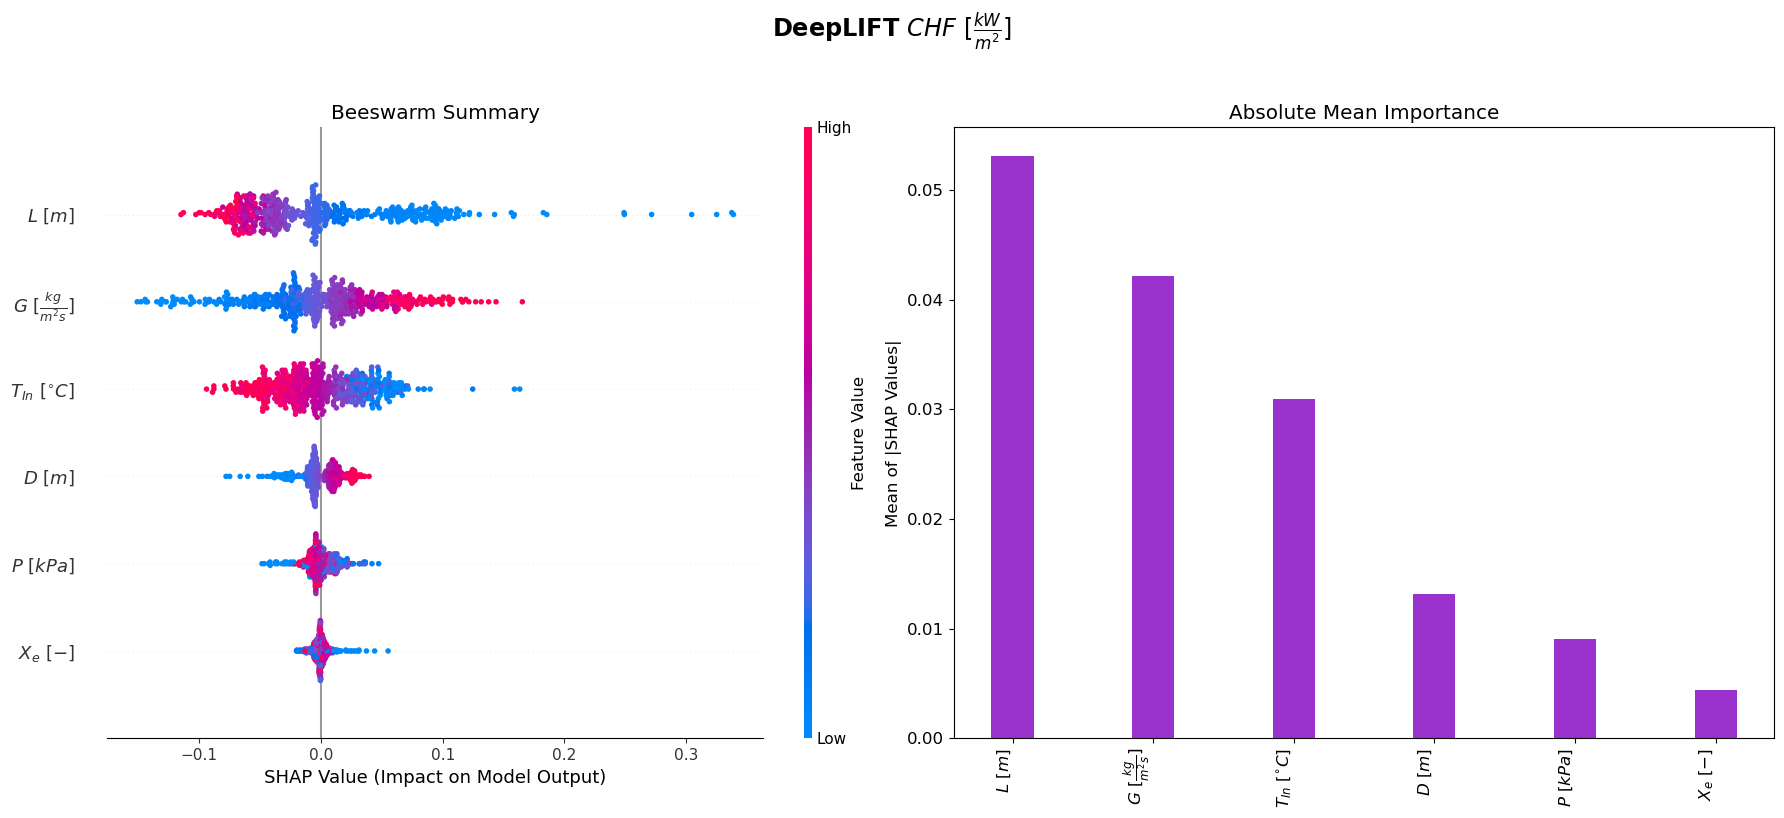

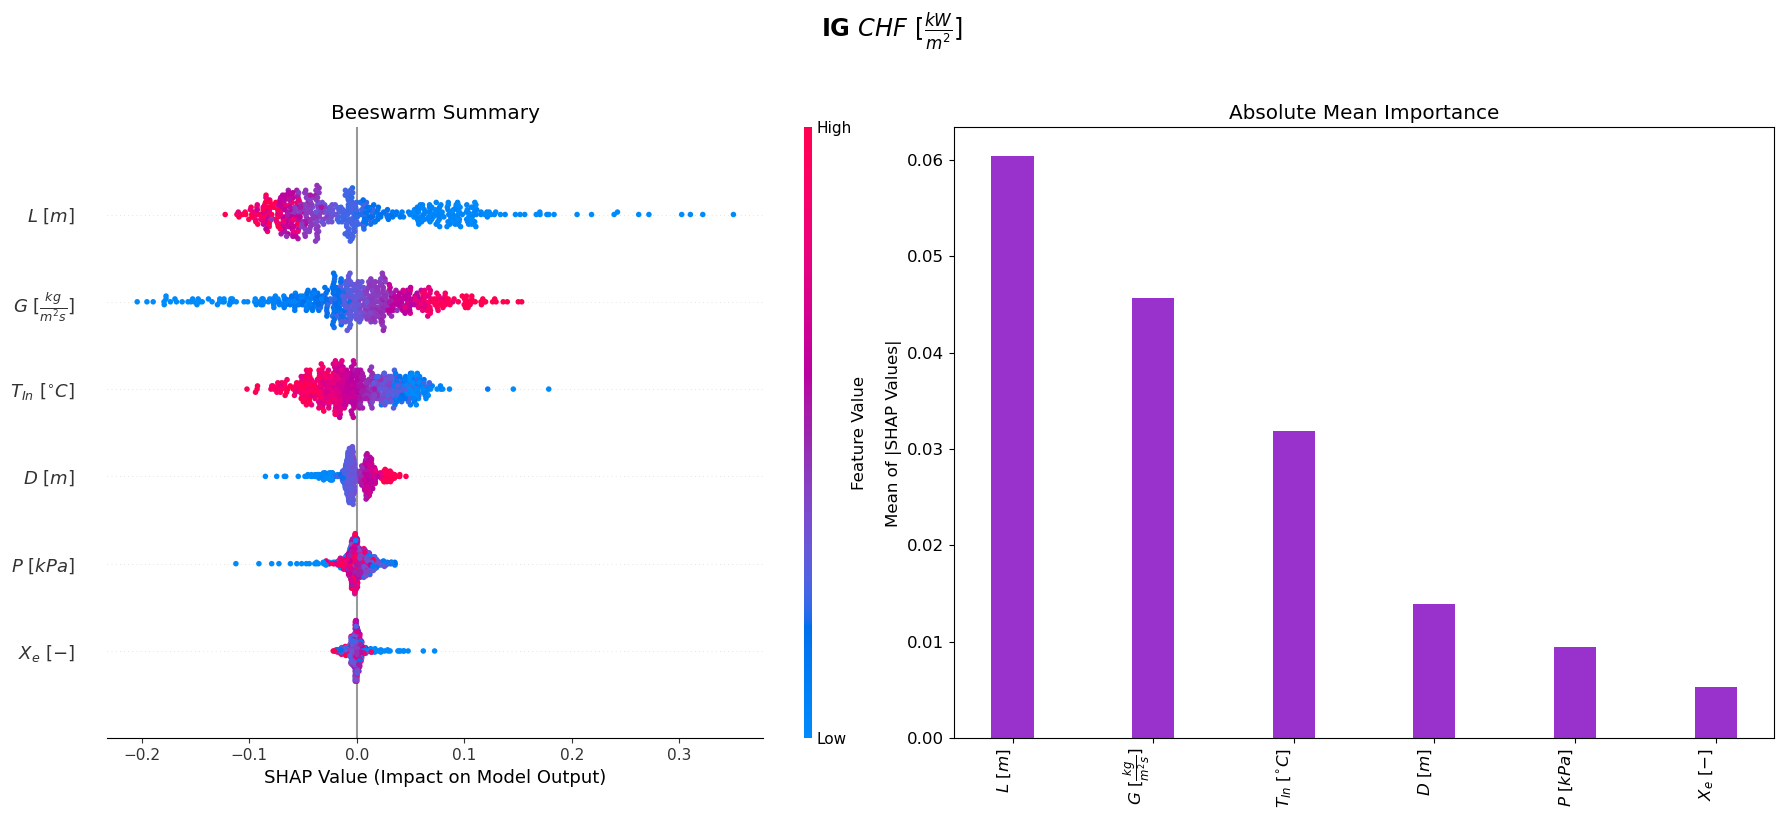

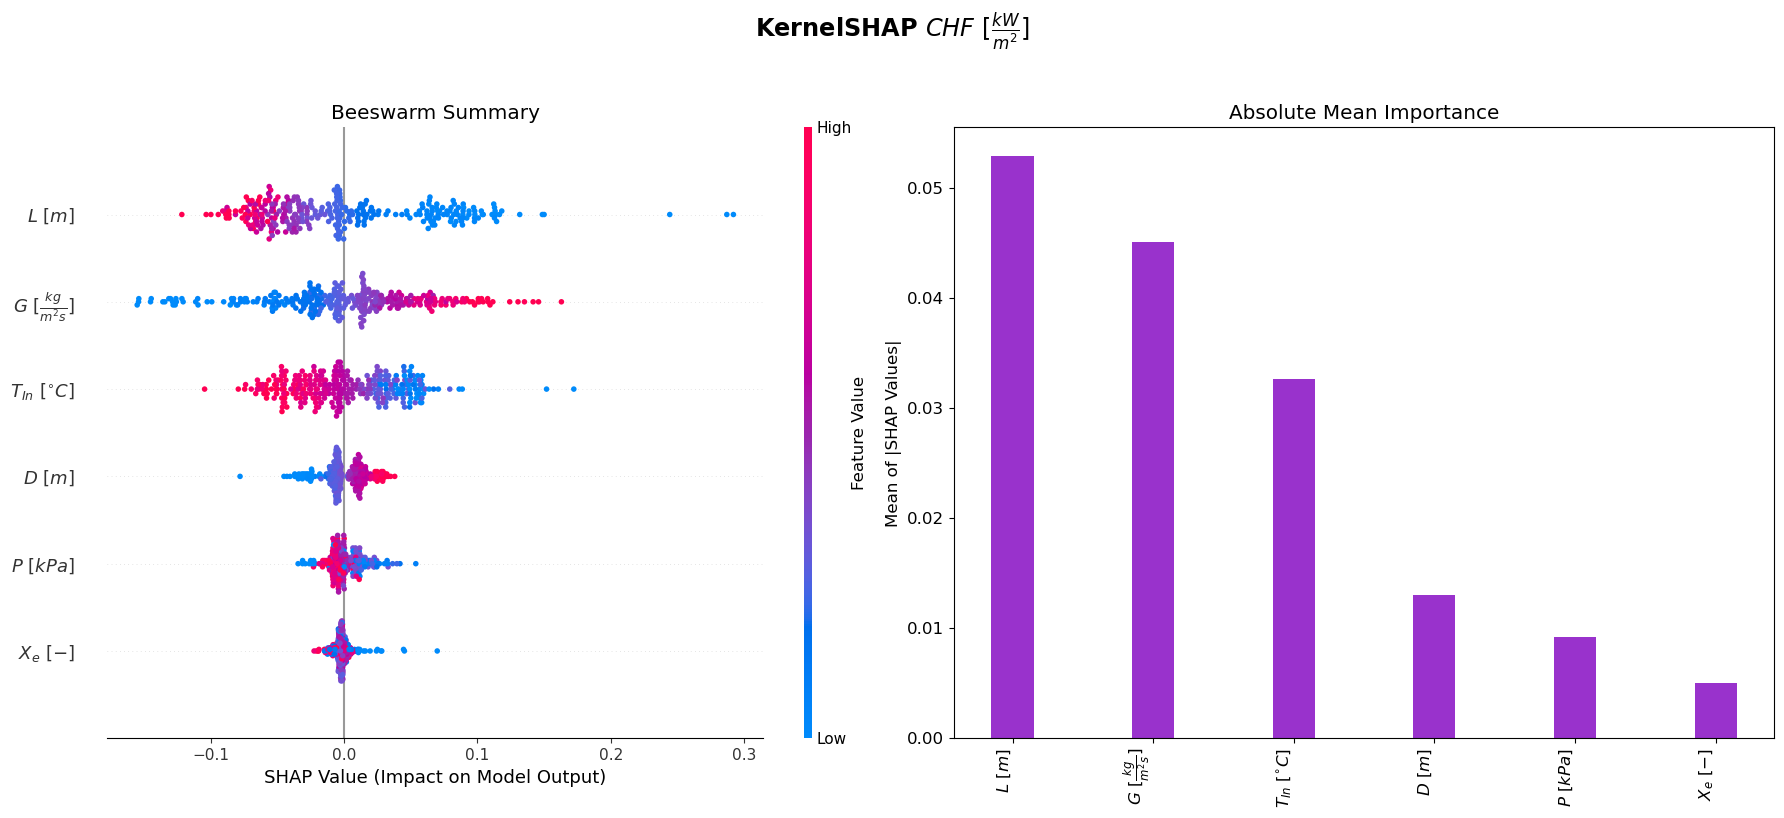

In [19]:
explainer.postprocess_results()
explainer.plot()



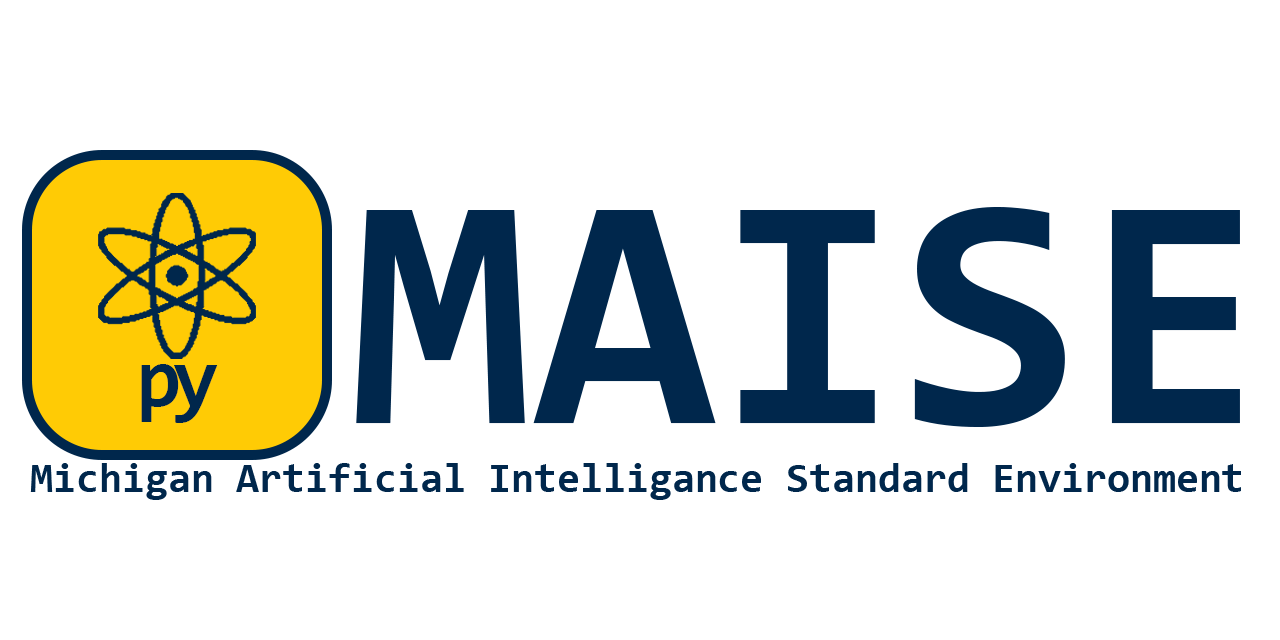